In [1]:
import numpy as np
import pandas as pd
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import researchpy as rp
import statsmodels.api as sm
import scipy.interpolate as interp

sys.path.insert(1, '/Users/cagrierdem/Desktop/dev/Python/pyrcca/')
import rcca

import scipy.stats as ss

from librosa.util import normalize as norm
from librosa.core import get_duration

from scipy import signal
from scipy import interpolate
from scipy.signal import butter, filtfilt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.formula.api import ols

from dtw import dtw,accelerated_dtw

%matplotlib inline

/Users/cagrierdem/anaconda3/envs/gData/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/cagrierdem/anaconda3/envs/gData/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
d_path = "/Users/cagrierdem/Desktop/dat/guit_lab/"
p_path = '/Users/cagrierdem/Downloads/new_plots/'           #'/Users/cagrierdem/Desktop/dat/guit_plot/'

m_path = '/Users/cagrierdem/Desktop/dat/guit_lab/mocap/'
datdir = "/Users/cagrierdem/Desktop/dat/guitar_raw/"

tasks = ["bending_soft_70",
         "bending_strong_70",
         'on-off_soft_70',
         'on-off_strong_70',
         'sustained_soft_70',
         'sustained_strong_70',
         'iterative_soft_70',
         'iterative_strong_70']

participant = []
for people in os.listdir(os.path.join(d_path)):
    if people.startswith('p'):
        participant.append(people)
participant = sorted(participant)
participant.remove('p23') #participant_23 data is broken :((

savedtasks = []
for task in tasks:
    savedtasks.append(str(task)+"_all_emg_segments")
    savedtasks.append(str(task)+"_all_rms_segments")
    savedtasks.append(str(task)+"_all_sound_segments")
    
print('Each of {} participants has {} tasks.'.format(len(participant), len(tasks)))

Each of 31 participants has 8 tasks.


In [3]:
def normalize(l):
    max_value = max(l)
    min_value = min(l)
    k = []
    for i in range(0, len(l)):
        k.append((l[i] - min_value) / (max_value - min_value))
    return np.array(k)

def energy_rms(y, hop_length=25, frame_length=100, sr=2000):
    y = np.array(y)
    
    energy = np.array([
        np.sum((y[i:i+frame_length]**2))
        for i in range(0, len(y), hop_length)
    ])
    
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    rms_timeline = librosa.frames_to_time(range(len(rms)), sr=sr, hop_length=hop_length)
    
#     return normalize(energy), normalize(rms), rms_timeline
    return norm(energy), norm(rms), rms_timeline


def emg_to_rms(emg_segments):
    b, a = butter(4, 20, fs=2000.0, btype = 'highpass') #4th order 20hz cut-off high-pass
    d, c = butter(4, 200, fs=2000.0, btype = 'lowpass') #4th order 200hz cut-off low-pass
    for s in emg_segments:
        rms_ch=[]
        for ch in range(4):
            rmss = pd.DataFrame(energy_rms(filtfilt(d, c, filtfilt(b, a, emg_segments.iloc[:,ch].values)))[0])
            rms_ch.append(rmss)
        rms_ch = pd.concat(rms_ch, axis=1)
        rms_ch.columns = ["ch1", "ch2", 'ch3', 'ch4']
    return rms_ch

def tkeo(x):
    b, a = butter(4, 20, fs=2000.0, btype = 'highpass') #4th order 20hz cut-off high-pass
    d, c = butter(4, 200, fs=2000.0, btype = 'lowpass') #4th order 200hz cut-off low-pass
    x_f = filtfilt(d, c, filtfilt(b, a, np.array(x)))
    x_tkeo = np.asarray(x_f)
    y = np.copy(x_tkeo)
    # Teager–Kaiser Energy operator
    y[1:-1] = x[1:-1]*x[1:-1] - x[:-2]*x[2:]
    # correct the data in the extremities
    y[0], y[-1] = y[1], y[-2]
    t = librosa.frames_to_time(range(len(x)), sr=2000, hop_length=25)
    return norm(y),t

def emg_to_tkeo(emg_segments):
    for s in emg_segments:
        rms_ch=[]
        for ch in range(4):
            rmss = pd.DataFrame(tkeo(emg_segments.iloc[:,ch].values)[0])
            rms_ch.append(rmss)
        rms_ch = pd.concat(rms_ch, axis=1)
        rms_ch.columns = ["ch1", "ch2", 'ch3', 'ch4']
    return rms_ch

In [4]:
savedtasks[2]

'bending_soft_70_all_sound_segments'

In [5]:
#load raw-EMG, sound RMS and raw sound
emg_all=[]
rms_all=[]
snd_all=[] 
for i in range(len(participant)):
    st_nr=0
    each_peep_emg = []
    each_peep_rms = []
    each_peep_snd = []
    for t in range(len(tasks)):
        st_nr+=3
        etask = pd.read_pickle(os.path.join(d_path, participant[i], tasks[t], participant[i]+'_'+savedtasks[st_nr-3]))
        rtask = pd.read_pickle(os.path.join(d_path, participant[i], tasks[t], participant[i]+'_'+savedtasks[st_nr-2]))
        stask = pd.read_pickle(os.path.join(d_path, participant[i], tasks[t], participant[i]+'_'+savedtasks[st_nr-1]))
        each_peep_emg.append(etask)
        each_peep_rms.append(rtask)
        each_peep_snd.append(stask)
        
    emg_all.append(each_peep_emg)
    rms_all.append(each_peep_rms)
    snd_all.append(each_peep_snd)

In [6]:
# def seq(seq_list):
#     '''return the selected segments' channels'''
#     nrs=[]
#     m = 0
#     for k in range(1,7):
#         m += 4
#         seqa = np.arange(1, 5) + m - 4
#         nrs.append(seqa)              
#     return [nrs[n-1] for n in seq_list]

# #Manually choose 1 of 6 segments for each of 8 tasks from each participant:
# chosen_seqs = {'p01': [4,1,1,1,1,1,1,1], 'p02': [1,1,2,1,2,1,1,5], 'p03': [6,6,2,3,3,5,5,1],
#                'p04': [2,2,4,3,5,5,3,5], 'p05': [2,2,1,1,5,5,3,5], 'p06': [3,4,1,3,2,1,1,5],
#                'p07': [2,1,1,1,3,6,1,1], 'p08': [2,4,3,5,3,5,1,1], 'p09': [1,2,1,2,1,1,5,5],
#                'p10': [1,2,5,2,2,2,3,1], 'p11': [1,2,1,2,3,2,5,3], 'p12': [2,6,3,5,4,2,3,1],
#                'p13': [4,2,4,2,1,2,5,5], 'p14': [1,2,1,3,1,5,1,5], 'p15': [3,1,5,5,2,3,5,3],
#                'p16': [3,5,1,5,6,5,3,5], 'p17': [6,2,2,6,1,1,5,3], 'p18': [4,6,2,1,5,6,5,1],
#                'p19': [5,2,5,2,2,2,5,3], 'p20': [1,4,3,4,4,5,1,1], 'p21': [1,6,6,6,4,1,1,1],
#                'p22': [3,6,2,6,4,2,5,1], 'p24': [6,2,5,4,4,5,1,3], 'p25': [1,2,2,6,4,5,3,5],
#                'p26': [6,6,5,1,4,4,1,5], 'p27': [1,4,2,4,2,5,5,1], 'p28': [2,3,2,6,1,5,5,5],
#                'p29': [5,2,2,5,2,2,3,3], 'p30': [1,6,2,3,1,6,1,3], 'p31': [4,2,3,2,6,1,1,5],
#                'p32': [4,2,6,1,3,1,1,3]}

In [7]:
# def seq(seq_list):
#     '''return the selected segments' channels'''
#     nrs=[]
#     m = 0
#     for k in range(1,7):
#         m += 4
#         seqa = np.arange(1, 5) + m - 4
#         nrs.append(seqa)              
#     return [nrs[n-1] for n in seq_list]

# #Manually choose 1 of 6 segments for each of 8 tasks from each participant:
# chosen_seqs = {'p01': [4,4,1,1,2,2,2,2], 'p02': [2,4,3,1,2,2,2,4], 'p03': [6,6,3,3,4,6,6,2],
#                'p04': [2,2,3,3,6,4,3,6], 'p05': [2,2,1,1,6,6,4,6], 'p06': [2,4,1,3,2,2,2,6],
#                'p07': [2,2,1,1,4,6,2,2], 'p08': [2,4,3,5,4,6,2,2], 'p09': [4,2,1,3,2,2,6,6],
#                'p10': [2,2,5,3,2,2,4,2], 'p11': [4,2,1,3,4,2,6,2], 'p12': [2,6,3,5,4,2,2,2],
#                'p13': [4,2,3,3,2,2,5,6], 'p14': [4,2,1,3,2,6,2,6], 'p15': [2,4,5,5,2,4,6,4],
#                'p16': [2,4,1,5,6,4,4,6], 'p17': [6,2,3,5,2,2,6,4], 'p18': [4,6,3,1,6,6,6,2],
#                'p19': [6,2,5,3,2,2,6,4], 'p20': [4,4,3,5,4,4,2,2], 'p21': [2,6,5,5,4,2,2,2],
#                'p22': [2,6,3,5,4,2,6,2], 'p24': [6,2,5,5,4,4,2,2], 'p25': [2,2,2,5,4,6,4,6],
#                'p26': [6,6,5,1,4,4,2,6], 'p27': [2,4,1,5,2,4,6,2], 'p28': [2,2,2,5,2,6,4,6],
#                'p29': [4,2,3,5,2,2,4,4], 'p30': [2,6,1,3,2,6,2,4], 'p31': [6,2,3,2,6,2,2,6],
#                'p32': [4,2,5,1,4,2,2,4]}

In [8]:
def seq(seq_list):
    '''return the selected segments' channels'''
    nrs=[]
    m = 0
    for k in range(1,7):
        m += 4
        seqa = np.arange(1, 5) + m - 4
        nrs.append(seqa)              
    return [nrs[n-1] for n in seq_list]

#Manually choose 1 of 6 segments for each of 8 tasks from each participant:
chosen_seqs = {'p01': [4,2,1,1,1,1,1,1], 'p02': [2,2,3,1,3,1,1,5], 'p03': [6,6,3,3,3,5,5,1],
               'p04': [2,2,5,3,5,5,3,5], 'p05': [2,2,1,1,5,5,3,5], 'p06': [4,4,1,3,3,1,1,5],
               'p07': [2,2,1,1,3,5,1,1], 'p08': [2,4,3,5,3,5,1,1], 'p09': [2,2,1,3,1,1,5,5],
               'p10': [2,2,5,3,3,3,3,1], 'p11': [2,2,1,3,3,2,5,3], 'p12': [2,6,3,5,5,2,3,1],
               'p13': [4,2,5,3,1,3,5,5], 'p14': [2,2,1,3,1,5,1,5], 'p15': [4,2,5,5,3,3,5,3],
               'p16': [4,6,1,5,5,5,3,5], 'p17': [6,2,2,5,1,1,5,3], 'p18': [4,6,3,1,5,5,5,1],
               'p19': [6,2,5,3,3,3,5,3], 'p20': [2,4,3,5,5,5,1,1], 'p21': [2,6,5,5,5,1,1,1],
               'p22': [4,6,3,5,5,3,5,1], 'p24': [6,2,5,5,5,5,1,3], 'p25': [2,2,3,5,5,5,3,5],
               'p26': [6,6,5,1,5,5,1,5], 'p27': [4,4,3,3,2,5,5,1], 'p28': [2,4,3,5,1,5,5,5],
               'p29': [6,2,3,5,3,3,3,3], 'p30': [2,6,3,3,1,5,1,3], 'p31': [4,2,3,3,5,1,1,5],
               'p32': [4,2,5,1,3,1,1,3]}

In [9]:
# filter & feature-extract EMG, and store all data in a common dict
allof={}
for nr, peep in enumerate(participant): 
    emg_dict = {}
    rms_dict = {}
    snd_dict = {}
    raw_dict = {}
    tkeo_dict = {}
    for t in range(8):
        selected_seqs1 = emg_to_rms(emg_all[nr][t].iloc[:,seq(chosen_seqs[peep])[t]])
        emg_dict[str(tasks[t])[:-3]] = selected_seqs1
        
        selected_seqs2 = rms_all[nr][t].iloc[:,chosen_seqs[peep][t]]
        rms_dict[str(tasks[t])[:-3]] = selected_seqs2
        
        selected_seqs3 = snd_all[nr][t].iloc[:,chosen_seqs[peep][t]]
        snd_dict[str(tasks[t])[:-3]] = selected_seqs3
        
        selected_seqs4 = emg_all[nr][t].iloc[:,seq(chosen_seqs[peep])[t]]
        raw_dict[str(tasks[t])[:-3]] = selected_seqs4
        
        selected_seqs5 = emg_to_tkeo(emg_all[nr][t].iloc[:,seq(chosen_seqs[peep])[t]])
        tkeo_dict[str(tasks[t])[:-3]] = selected_seqs5

    allof[peep] = {'emg': emg_dict, 'rms': rms_dict, 'snd': snd_dict, 'raw': raw_dict , 'tkeo': tkeo_dict}

In [10]:
allof['p01']['rms']['sustained_strong'].shape

(93,)

In [11]:
allof['p15']['emg']['bending_strong'].shape

(344, 4)

In [12]:
def decompose(sig, fq):
    '''return the trend of the decomposed signal'''
    decomposition = seasonal_decompose(sig, model='additive', freq=fq)
    sig_trend = decomposition.trend.dropna().reset_index(drop=True)
    return sig_trend, decomposition

def dickey_fuller_test(sig):
    """p-value > 0.05: non-stationary.
       p-value <= 0.05: stationary."""
    pvalue = adfuller(sig)
    return pvalue[1]

def mean_sd(sig):
    '''return the Mean and SD of an array'''
    stat = rp.summary_cont(sig).iloc[:,[2,3]]
    return stat

def mean_of_all(task, data):
    '''return the mean array of the same task accross all participants'''
    concat=[]
    for idx, p in enumerate(participant):
        if data == 'rms':
            df = allof[p][data][task].copy()
            df=pd.DataFrame(df)
            df.columns = ["rms_mean"]
        elif data == 'snd':
            df = allof[p][data][task].copy()
            df=pd.DataFrame(df)
            df.columns = ["snd_mean"]
        else:
            chz=[]
            for ch in range(4):
                dfe = allof[p][data][task].copy().iloc[:,[ch]]
                chz.append(dfe)
            df=np.concatenate(chz, axis=1)
            df=pd.DataFrame(df)
            df.columns = ["ch1_mean", "ch2_mean", 'ch3_mean', 'ch4_mean']

        concat.append(df)
    concat = pd.concat(concat)
    by_row_index = concat.groupby(concat.index)
    df_means = by_row_index.mean()
    
    return df_means

def mean_two(task1, task2):
    df1 = task1.copy()
    df2 = task2.copy()
    concat = pd.concat([df1, df2])
    by_row_index = concat.groupby(concat.index)
    df_means = by_row_index.mean()
    return df_means

In [13]:
p27rms = allof['p27']['rms']['iterative_strong']
p27emg1 = allof['p27']['emg']['iterative_strong'].ch1
p27emg1_tkeo = allof['p27']['tkeo']['iterative_strong'].ch1
p27emg2 = allof['p27']['emg']['iterative_strong'].ch2
p27emg2_tkeo = allof['p27']['tkeo']['iterative_strong'].ch2
p27emg3 = allof['p27']['emg']['iterative_strong'].ch3
p27emg4 = allof['p27']['emg']['iterative_strong'].ch4
p27_t = librosa.frames_to_time(range(len(p27emg1)), sr=2000, hop_length=25)
p27_ttkeo = librosa.frames_to_time(range(len(p27emg1_tkeo)), sr=2000, hop_length=25)

In [14]:
# p10emg1

(-0.05, 1)

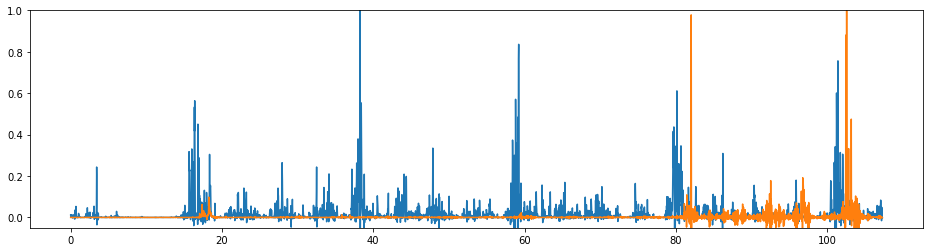

In [15]:
plt.figure(figsize=(16,4))
plt.plot(p27_ttkeo, p27emg1_tkeo)
plt.plot(p27_ttkeo, p27emg2_tkeo)
plt.ylim(-0.05,1)

([], <a list of 0 Text yticklabel objects>)

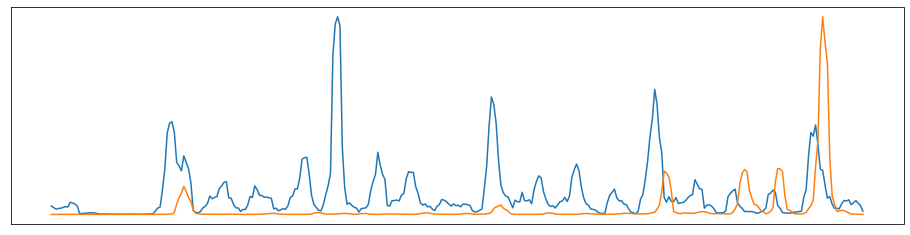

In [16]:
plt.figure(figsize=(16,4))
plt.plot(p27_t, p27emg1)
plt.plot(p27_t, p27emg2)
plt.xticks([])
plt.yticks([])

# plt.savefig(os.path.join(p_path, "p10_iterative.png"), bbox_inches='tight')

In [17]:
#mean of both hands
#but now it's only with extensor channels. try it with flexor too.

# dff1 = mean_of_all('sustained_strong', 'emg').ch1_mean
# dff2 = mean_of_all('sustained_strong', 'emg').ch3_mean
# df_both = pd.concat([dff1, dff2])
# both_by_row_index = df_both.groupby(df_both.index)
# df_both_means = both_by_row_index.mean()

# decompose(df_both_means, 10)[1].plot()

In [18]:
# #Trend --> mean val

# people_stats=[]
# for p in participant:
#     stats_all=[]
#     for dat in ['emg', 'rms', 'snd']:
#         stats=[]
#         for t in tasks:
#             signal_trend = decompose(allof[p][dat][t[:-3]], 10)[0]
#             signal_stat = mean_sd(signal_trend)
#             if signal_stat.shape[0] == 4:
#                 signal_stat.index = [str(p)+'_'+str(dat)+'_'+t+'_ch{}'.format(ch) for ch in range(1,5)]
#             else:
#                 signal_stat.index = [str(p)+'_'+str(dat)+'_'+t]
#             stats.append(signal_stat)
#         stats_all.append(stats)
#     people_stats.append(stats_all) 


    
# def mean_task(tindex, dindex, kind='Mean'):
#     '''
#     return a single value for the 'Mean' or 'SD' of all tasks of all participants
#     tindex is index for task
#     dindex is index for data (emg or rms)
#     '''
#     means = []
#     for p in range(len(participant)):
#         m = np.array(people_stats[p][dindex][tindex][[kind]]).transpose()
#         means.append(m)

#     if dindex == 0:
#         means = pd.DataFrame(data=np.concatenate(means), 
#                              columns = [str(tasks[tindex])[:-3]+'_ch{}_{}'.format(c, kind) for c in range(4)]) 
#     elif dindex == 1:
#         means = pd.DataFrame(data=np.concatenate(means), 
#                              columns = [str(tasks[tindex])[:-3]+"_rms_{}".format(kind)])
#     else:
#         means = pd.DataFrame(data=np.concatenate(means), 
#                      columns = [str(tasks[tindex])[:-3]+"_snd_{}".format(kind)])
#     means.index += 1                                                               
                                                                                                                                                                         
#     return means

In [19]:
#make it in for-loop for interpolating all!
def interp_two(sig, refsig=allof['p01']['emg']['bending_soft'].ch1.values):
    '''return sound RMS that matches the emg size'''
#     ref = np.array(allof['p01']['emg']['bending_soft'].ch1)
    ref = refsig
    arr = np.array(sig)
    arr_interp = interp.interp1d(np.arange(arr.size),arr)
    arr_new = arr_interp(np.linspace(0, arr.size-1, ref.size))
    return arr_new

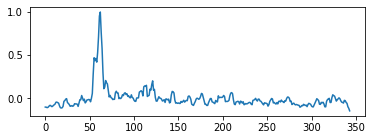

In [20]:
#PCA
from sklearn.preprocessing import StandardScaler # for standardizing the Data
from sklearn.decomposition import PCA # for PCA calculation

def pca(sig, pc=1):
    
    num_components = pc
    df = sig
    X = df.values
    sc = StandardScaler()
    X_std = sc.fit_transform(X)
    pca = PCA(num_components, svd_solver='full') 
    X_pca = pca.fit_transform(X_std)

    return norm(X_pca)


deneme_pca = pca(allof['p04']['emg']['sustained_strong'])
plt.figure(figsize=(6,2))
plt.plot(deneme_pca)

In [21]:
def concat_t(t):
    alltopcas=[]
    for p in participant:
        dfarr = allof[p]['emg'][t]
        alltopcas.append(dfarr)
    alltopcas=pd.concat(alltopcas,  axis=1)
    return alltopcas

In [22]:
# # https://github.com/jakevdp/wpca/blob/master/WPCA-Example.ipynb

# from wpca import PCA, WPCA, EMPCA

# def plot_results(ThisPCA, X, weights=None, Xtrue=None, ncomp=2):
#     # Compute the standard/weighted PCA
#     if weights is None:
#         kwds = {}
#     else:
#         kwds = {'weights': weights}
    
#     # Compute the PCA vectors & variance
#     pca = ThisPCA(n_components=2).fit(X, **kwds)
    
#     # Reconstruct the data using the PCA model
#     Y = ThisPCA(n_components=ncomp).fit_reconstruct(X, **kwds)
        
#     # Create the plots
#     fig, ax = plt.subplots(2, 2, figsize=(16, 6))
#     if Xtrue is not None:
#         ax[0, 0].plot(Xtrue[:10].T, c='gray', lw=1)
#         ax[1, 1].plot(Xtrue[:10].T, c='gray', lw=1)
#     ax[0, 0].plot(X[:10].T, c='black', lw=1)
#     ax[1, 1].plot(Y[:10].T, c='black', lw=1)
    
#     ax[0, 1].plot(pca.components_[:ncomp].T, c='black')
    
#     ax[1, 0].plot(np.arange(1, 11), pca.explained_variance_ratio_)
#     ax[1, 0].set_xlim(1, 10)
#     ax[1, 0].set_ylim(0, None)
    
#     ax[0, 0].xaxis.set_major_formatter(plt.NullFormatter())
#     ax[0, 1].xaxis.set_major_formatter(plt.NullFormatter())
    
#     ax[0, 0].set_title('Input Data')
#     ax[0, 1].set_title('First {0} Principal Vectors'.format(ncomp))
#     ax[1, 1].set_title('Reconstructed Data ({0} components)'.format(ncomp))
#     ax[1, 0].set_title('PCA variance ratio')
#     ax[1, 0].set_xlabel('principal vector')
#     ax[1, 0].set_ylabel('proportion of total variance')
    
#     fig.suptitle(ThisPCA.__name__, fontsize=16)

In [23]:
# X2 = np.matrix(Xtrue)
# X_dm = X2 - np.mean(X2, axis=0)

# Cov_X = np.cov(X_dm, rowvar=False)
# eigen = np.linalg.eig(Cov_X)
# eig_values_X = np.matrix(eigen[0])
# eig_vectors_X = np.matrix(eigen[1])

# Y_dm = X_dm * eig_vectors_X

# y_trans = Y_dm.copy()

# plt.plot(y_trans)

# # https://www.youtube.com/watch?v=nakmpAQ6z-g

In [24]:
# https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition

class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

In [25]:
def stack_people(task, ch=1):
    '''Return stacks of EMG channels and sound RMS'''
    
    emg_stacks=[]
    rms_stacks=[]
    for p in participant:

        df = allof[p]['emg'][task].iloc[:,ch-1]
        dfr = allof[p]['rms'][task]
        dfr_norm = interp_two(dfr, df)
        dfrn = pd.DataFrame(dfr_norm)
        
        emg_stacks.append(df)
        rms_stacks.append(dfrn)
    emg_stacks = pd.concat(emg_stacks, axis=1)
    rms_stacks = pd.concat(rms_stacks, axis=1)

    return emg_stacks, rms_stacks


def stack_tasks(ch):
    
    '''Returns stacked channels of EMG across all tasks and participants'''
    
    soft_stacks=[]
    strong_stacks=[]
    
    for t in tasks:
        
        if t[:-3].endswith('soft'):
            df = stack_people(t[:-3], ch)
        else:
            dfe = stack_people(t[:-3], ch)
            
            soft_stacks.append(df)
            strong_stacks.append(dfe)
        
    soft_stacks = pd.concat(soft_stacks, axis=1)
    strong_stacks = pd.concat(strong_stacks, axis=1)
        
    return soft_stacks, soft_stacks  


from sklearn import preprocessing

def mixed_pc(task, n=2, ch_start=1, ch_end=4):
    
    '''Return n principal components (default=2) of all EMG channels across all participants'''

    chz=[]
    min_max_scaler = preprocessing.MinMaxScaler()
    for c in range (ch_start, ch_end+1):
        susdf = stack_people(task, c)[0]
        chz.append(susdf)
    chz=pd.concat(chz,axis=1)
    chz_pc = pca(chz,n)
    chz_pc_norm = min_max_scaler.fit_transform(chz_pc)
    chz_pc_df = pd.DataFrame(chz_pc_norm)
    chz_pc_df.columns = ['PC1', 'PC2']
    
    rms_pc = pca(stack_people(task)[1], n)
    rms_df = pd.DataFrame(rms_pc)
    rms_df.columns = ['PC1', 'PC2']
    
    return chz_pc_df #, rms_df



def get_trend(task, data='emg', window=10):
    
    '''Decompose and returns the PCs of EMG and average Sound RMS, using Singular-Spectrum Analysis'''
    
    min_max_scaler = preprocessing.MinMaxScaler()
    pc_trends=[]
    for i in range(1,3):    #assuming 2PCs
        
        emg_pc = mixed_pc(task)['PC'+str(i)]
        X = SSA(emg_pc, window)
        trend = X.reconstruct(0)
        trendz = min_max_scaler.fit_transform(pd.DataFrame(trend))
        pc_trends.append(pd.DataFrame(trendz))
    pc_trends=pd.concat(pc_trends, axis=1) 
    
    rms_frames = []
    for p in participant:
        
        rms_df = allof[p]['rms'][task]
        rms_frames.append(rms_df)
        
    rms_frames = pd.concat(rms_frames)
    by_row_index = rms_frames.groupby(rms_frames.index)
    rms_mean = by_row_index.mean()
    
    R = SSA(rms_mean, window)
    trendr = R.reconstruct(0)
    trendn = min_max_scaler.fit_transform(pd.DataFrame(trendr))
    rms_inter = interp_two(np.concatenate(trendn), emg_pc)
    rms_trend = pd.DataFrame(rms_inter)
    
    if data == 'emg':
        finalframe = pc_trends
        finalframe.columns = ['PC1', 'PC2']
    else:
        finalframe = rms_trend
        finalframe.columns = ['RMS']
    
    return finalframe


def norm_of(l, min_val=0):
    max_value = max(l)
    min_value = min(l)
    k = []
    for i in range(0, len(l)):
        if min_val == 0:
            k.append((l[i] - min_value) / (max_value - min_value))
        elif min_val == -1:
            k.append( 2*(l[i] - min_value) / (max_value - min_value)-1 )
    return np.array(k)


def get_trend2(task, data='emg', window=10, norm=False):  #without scaling into (0,1)
    
    '''Decompose and returns the PCs of EMG and average Sound RMS, using Singular-Spectrum Analysis'''
    
    pc_trends=[]
    for i in range(1,3):    #assuming 2PCs
        
        emg_pc = mixed_pc(task)['PC'+str(i)]
        X = SSA(emg_pc, window)
        trend = X.reconstruct(0)
        if norm:
            trend = norm_of(trend)
        pc_trends.append(pd.DataFrame(trend))
    pc_trends=pd.concat(pc_trends, axis=1) 
    
    rms_frames = []
    for p in participant:
        
        rms_df = allof[p]['rms'][task]
        rms_frames.append(rms_df)
        
    rms_frames = pd.concat(rms_frames)
    by_row_index = rms_frames.groupby(rms_frames.index)
    rms_mean = by_row_index.mean()
    
    R = SSA(rms_mean, window)
    trendr = R.reconstruct(0)
    if norm:
        trendr = norm_of(trendr)
    rms_inter = interp_two(trendr, emg_pc)
    rms_trend = pd.DataFrame(rms_inter)
    
    if data == 'emg':
        finalframe = pc_trends
        finalframe.columns = ['PC1', 'PC2']
    else:
        finalframe = rms_trend
        finalframe.columns = ['RMS']
    
    return finalframe

In [26]:
mixed_pc('sustained_strong').shape

(344, 2)

In [27]:
def dsplit(string):
    dynamics = string.split("_", 1)[1].split("_", 1)[0].capitalize()
    task = string.split("_", 1)[0].capitalize()
    return task, dynamics


def sns_pcprep(task, pc):  #BUNA EMG TIME EKLEMEN LAZIM!
    '''Return prepared data frame for sns plot'''
    
    arrlen = len(get_trend2(task+'_soft', 'emg').iloc[:,pc-1])
    ts = tasks.index(task+'_soft_70')
    tS = tasks.index(task+'_strong_70')
  
    softpc = pd.concat([mixed_pc(task+'_soft').iloc[:,pc-1],  
                        pd.DataFrame(arrlen*[dsplit(tasks[ts])[0]]),
                        pd.DataFrame(arrlen*[dsplit(tasks[ts])[1]])], 
                        axis=1)
    
    strongpc = pd.concat([mixed_pc(task+'_strong').iloc[:,pc-1], 
                         pd.DataFrame(arrlen*[dsplit(tasks[tS])[0]]),
                         pd.DataFrame(arrlen*[dsplit(tasks[tS])[1]])], 
                         axis=1)
    
    
    finalemean = pd.concat([softpc, strongpc], axis=0)
    finalemean = finalemean.reset_index(drop=True)
    finalemean.columns = ['EMG PC{}'.format(pc), 'Task', 'Dynamics']
    
    return finalemean


def sns_tprep(task, pc, window=10, norm=False):
    '''Return prepared data frame for sns plot'''
    
    arrlen = len(get_trend2(task+'_soft', 'emg').iloc[:,pc-1])
    ts = tasks.index(task+'_soft_70')
    tS = tasks.index(task+'_strong_70')
  
    softtrend = pd.concat([get_trend2(task+'_soft', 'emg', window, norm=norm).iloc[:,pc-1], 
                           get_trend2(task+'_soft', 'rms', window, norm=norm), 
                           pd.DataFrame(arrlen*[dsplit(tasks[ts])[0]]),
                           pd.DataFrame(arrlen*[dsplit(tasks[ts])[1]])], 
                           axis=1)
    
    strongtrend = pd.concat([get_trend2(task+'_strong', 'emg', window, norm=norm).iloc[:,pc-1], 
                             get_trend2(task+'_strong', 'rms', window, norm=norm), 
                             pd.DataFrame(arrlen*[dsplit(tasks[tS])[0]]),
                             pd.DataFrame(arrlen*[dsplit(tasks[tS])[1]])], 
                             axis=1)
    
    
    finalemean = pd.concat([softtrend, strongtrend], axis=0)
    finalemean = finalemean.reset_index(drop=True)
    finalemean.columns = ['EMG PC{} Trend'.format(pc), 'Sound Trend', 'Task', 'Dynamics']
    
    return finalemean

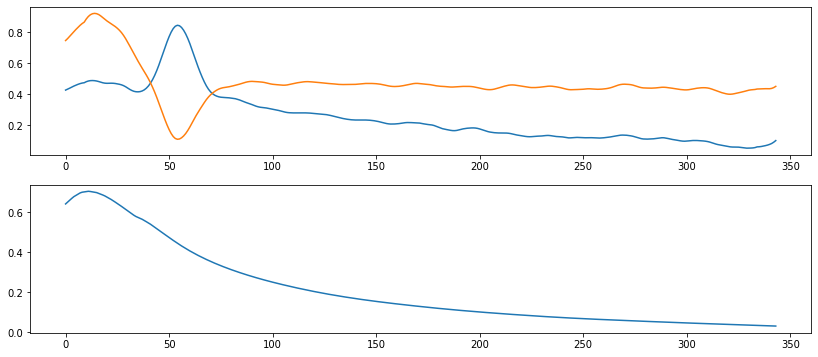

In [28]:
#MAKE SCATTERS WITH THESE!

emg_trend1 = get_trend2('bending_strong', 'emg').PC1
emg_trend2 = get_trend2('bending_strong', 'emg').PC2
rms_trend = get_trend2('bending_strong', 'rms')

plt.figure(figsize=(14, 6))
plt.subplot(2,1,1)
plt.plot(emg_trend1)
plt.plot(emg_trend2)
plt.subplot(2,1,2)
plt.plot(rms_trend)
# print(spearmanr(emg_trend1, rms_trend))

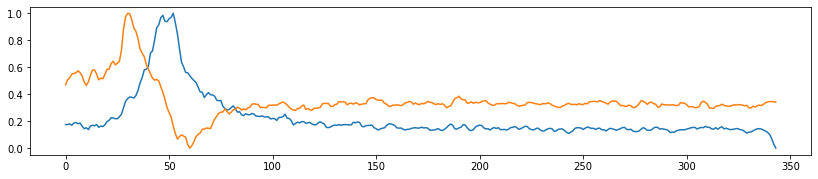

In [29]:
emgpc = mixed_pc('sustained_strong')
plt.figure(figsize=(14, 6))
plt.subplot(2,1,1)
plt.plot(emgpc)

In [30]:
# sns.set(style="whitegrid", font_scale=1.5)
# plt.figure(figsize=(12, 9))

# neworder = [4,5,6,7,0,1,2,3]
# taskso = [tasks[i] for i in neworder]

# for i,t in enumerate(taskso):
#     if t[:-3].endswith('soft'):
#         soft = t[:-3]
#     else:
#         strong = t[:-3]
        
#     plt.subplot(4,2,i+1)
#     plt.scatter(get_trend2(soft, 'rms'), mixed_pc(soft).iloc[:,i%2], 
#                 label='Soft', alpha=0.4)
#     plt.scatter(get_trend2(strong, 'rms'), mixed_pc(strong).iloc[:,i%2], 
#                 label='Strong', alpha=0.4)

# plt.tight_layout()
# plt.show()

In [31]:
# allof['p01']['raw']['sustained_strong'].head()

In [32]:
am1 = allof['p01']['emg']['iterative_strong'].ch1.values
am2 = allof['p01']['emg']['iterative_strong'].ch2.values
t_am = librosa.frames_to_time(range(len(am1)), sr=2000, hop_length=25)

In [33]:
# t_am

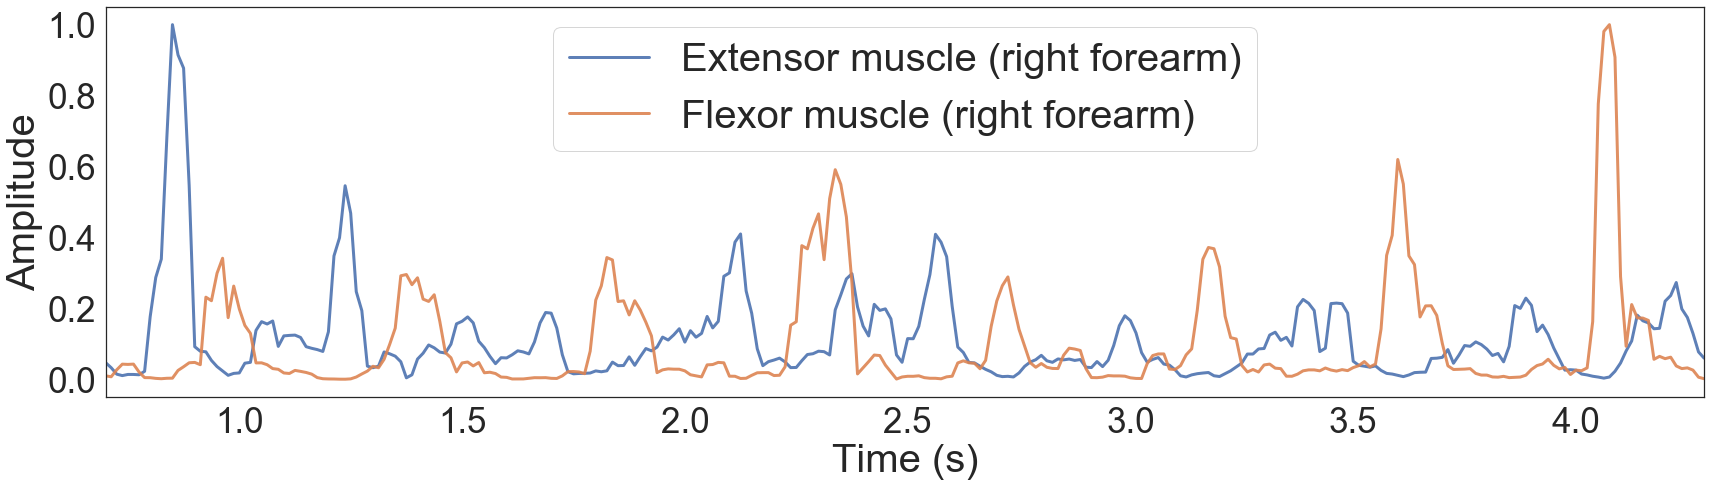

In [34]:
sns.set(style="white", font_scale=1.2)
plt.figure(figsize=(24,7))
plt.plot(t_am, abs(norm(am1)), alpha=0.9, label='Extensor muscle (right forearm)', linewidth=3)
plt.plot(t_am, abs(norm(am2)), alpha=0.9, label='Flexor muscle (right forearm)', linewidth=3)
# plt.title('Iterative')
plt.xlabel('Time (s)', fontsize=40)
plt.ylabel('Amplitude', fontsize=40)
plt.xlim(0.7, 4.2875)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.legend(fontsize=40)
plt.tight_layout()
plt.savefig(os.path.join(p_path, "iterative_example.png"), bbox_inches='tight')
plt.show()

In [35]:
def sync_comb(df, ref_df, how='right'):
    
    col_nr = df.shape[1]
    
    #find the nearest points in the timeline of the given dataframe
    time_points=[]
    for val in df.index:
        idx = (np.abs(ref_df.index-val)).argmin()
        time_points.append(ref_df.index.values[idx])
    
    new_df = df.copy()
    new_df.index = time_points
    
    combined = new_df.join(ref_df, how=how)
#     combined_i = combined.apply(pd.Series.interpolate)
    combined_i = combined.interpolate(method='index')
#     combined_i.index = get_time(combined, round(1/np.mean(np.diff(ref_df.index)),1))
    
    return combined_i.iloc[:,:col_nr], combined_i.iloc[:,col_nr:]

In [36]:
# def mean_of_all_rms(t):
#     '''return the mean array of the same SC task accross all participants'''
    
#     concat=[]
#     for idx, p in enumerate(participant):
#         df = allof[p]['rms'][t]
#         dfe=pd.DataFrame(df)
#         if ax == 0:
#             dfe.columns = ["Time"]
#         else:
#             dfe.columns = ["RMS mean"]
    
#         concat.append(dfe)
    
#     concat = pd.concat(concat)
#     by_row_index = concat.groupby(concat.index)
#     df_means = by_row_index.mean()
    
#     return df_means

# mean_of_all_rms('sustained_strong').plot()

In [37]:
# sync_comb(mean_of_all_rms('sustained_strong'), mixed_pc('sustained_strong').PC1)[0].shape

In [38]:
# rmsz=[]
# for t in tasks:
#     task = t[:-3]
#     new_rms = sync_comb(mean_of_all_rms(task), mixed_pc(task).PC1)[0]
#     rmsz.append(new_rms)

In [39]:
#  mixed_pc('sustained_soft')

In [201]:
for x in range(4):
    for y in range(2):
        print([x,y])

[0, 0]
[0, 1]
[1, 0]
[1, 1]
[2, 0]
[2, 1]
[3, 0]
[3, 1]


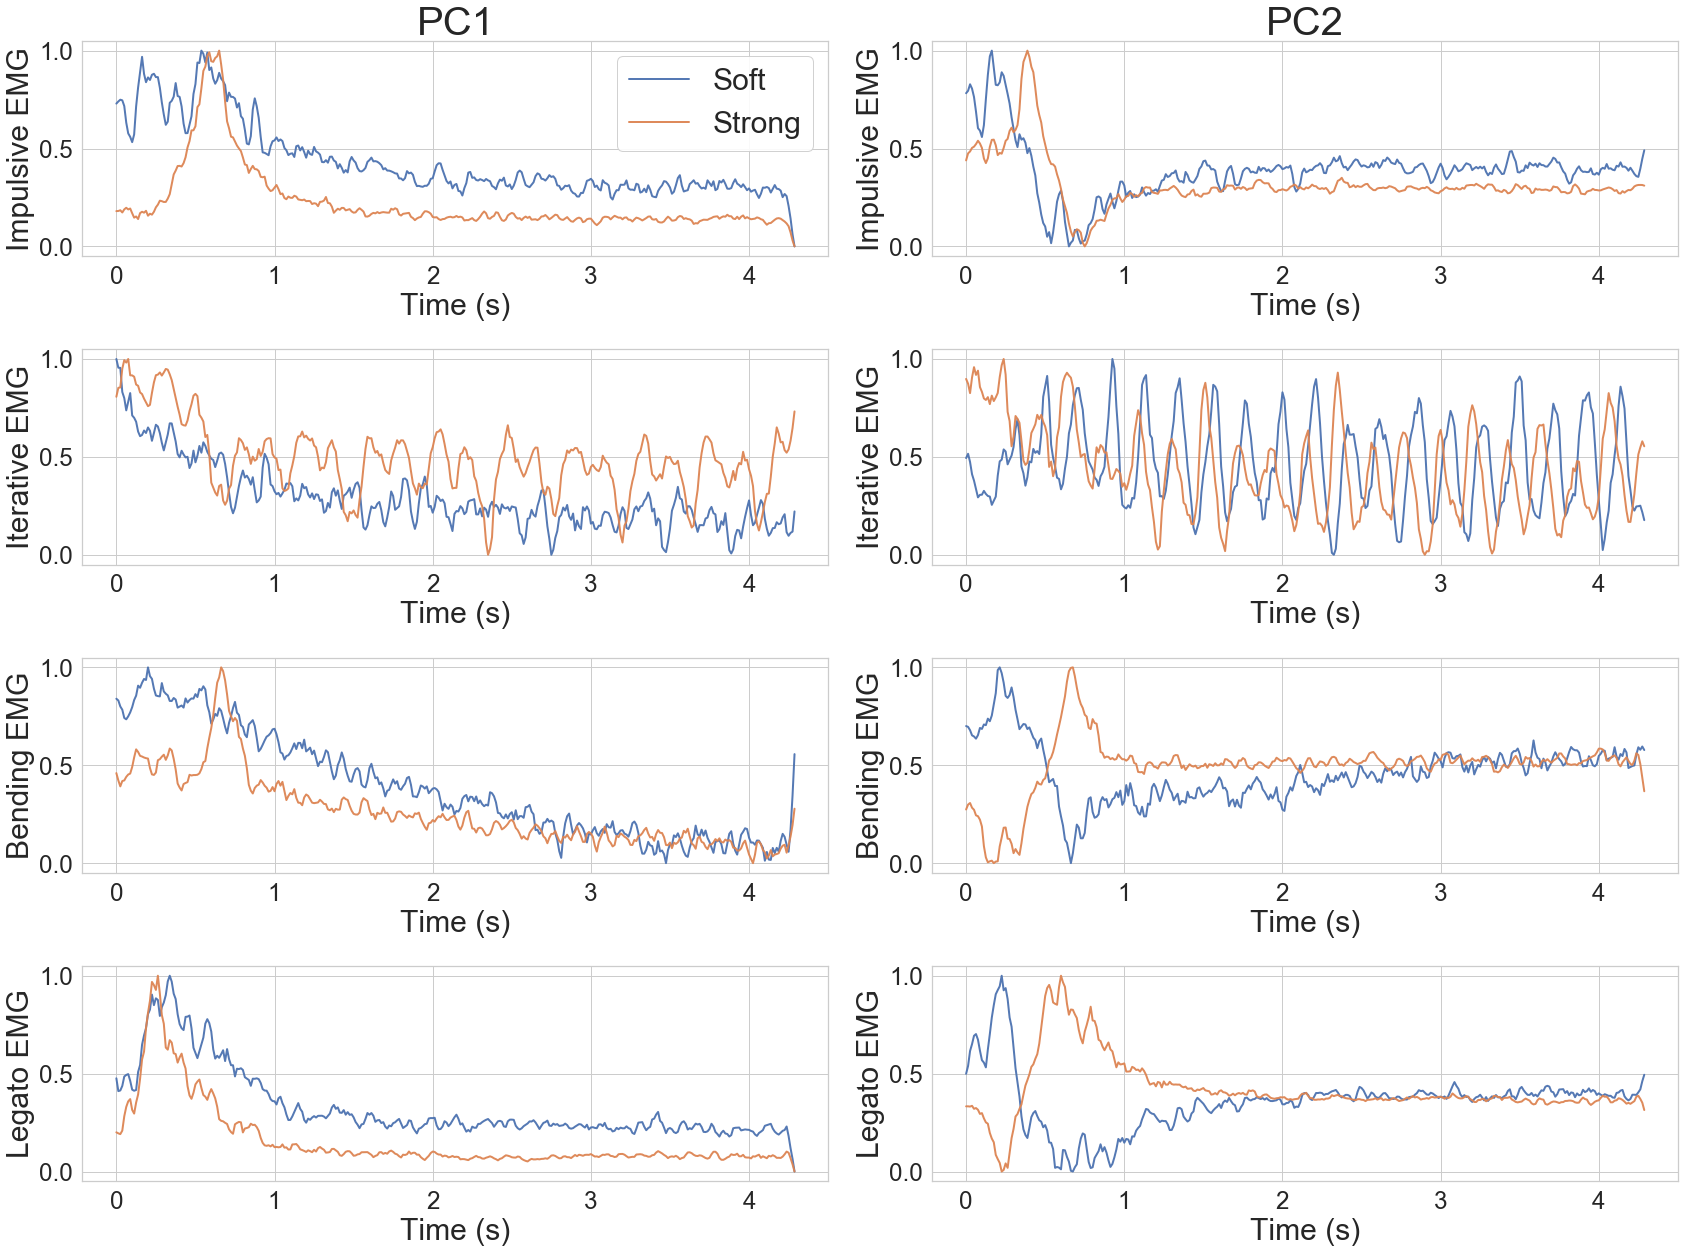

In [207]:
sns.set(style="whitegrid", font_scale=2.2)

emgpc_time = librosa.frames_to_time(range(len(emgpc.PC1.values)), sr=2000, hop_length=25)

alpha=0.95
linewidth=2
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=False, sharey=False, figsize=(24, 18))
# fig.text(0.5, 0.09, 'Time (s)', ha='center', fontsize=40)
# fig.text(0.06, 0.5, 'Normalized EMG', va='center', rotation='vertical', fontsize=40)

axs[0, 0].plot(emgpc_time, mixed_pc('sustained_soft').PC1, label='Soft', alpha=alpha, linewidth=linewidth)
axs[0, 0].plot(emgpc_time, mixed_pc('sustained_strong').PC1, label='Strong', alpha=alpha, linewidth=linewidth)
axs[0, 0].set_ylabel("Impulsive EMG", fontsize=30)
axs[0, 0].set_title('PC1', fontsize=40)

axs[0, 0].legend(frameon=True, framealpha=0.9, loc='upper right', fontsize=30)
axs[0, 1].plot(emgpc_time, mixed_pc('sustained_soft').PC2, label='Soft', alpha=alpha, linewidth=linewidth)
axs[0, 1].plot(emgpc_time, mixed_pc('sustained_strong').PC2, label='Strong', alpha=alpha, linewidth=linewidth)
axs[0, 1].set_ylabel("Impulsive EMG", fontsize=30)
axs[0, 1].set_title('PC2', fontsize=40)

axs[1, 0].plot(emgpc_time, mixed_pc('iterative_soft').PC1, label='Soft', alpha=alpha, linewidth=linewidth)
axs[1, 0].plot(emgpc_time, mixed_pc('iterative_strong').PC1, label='Strong', alpha=alpha, linewidth=linewidth)
axs[1, 0].set_ylabel("Iterative EMG", fontsize=30)
axs[1, 1].plot(emgpc_time, mixed_pc('iterative_soft').PC2, label='Soft', alpha=alpha, linewidth=linewidth)
axs[1, 1].plot(emgpc_time, mixed_pc('iterative_strong').PC2, label='Strong', alpha=alpha, linewidth=linewidth)
axs[1, 1].set_ylabel("Iterative EMG", fontsize=30)

axs[2, 0].plot(emgpc_time, mixed_pc('bending_soft').PC1, label='Soft', alpha=alpha, linewidth=linewidth)
axs[2, 0].plot(emgpc_time, mixed_pc('bending_strong').PC1, label='Strong', alpha=alpha, linewidth=linewidth)
axs[2, 0].set_ylabel("Bending EMG", fontsize=30)
axs[2, 1].plot(emgpc_time, mixed_pc('bending_soft').PC2, label='Soft', alpha=alpha, linewidth=linewidth)
axs[2, 1].plot(emgpc_time, mixed_pc('bending_strong').PC2, label='Strong', alpha=alpha, linewidth=linewidth)
axs[2, 1].set_ylabel("Bending EMG", fontsize=30)

axs[3, 0].plot(emgpc_time, mixed_pc('on-off_soft').PC1, label='Soft', alpha=alpha, linewidth=linewidth)
axs[3, 0].plot(emgpc_time, mixed_pc('on-off_strong').PC1, label='Strong', alpha=alpha, linewidth=linewidth)
# axs[3, 0].set_xlabel('Time (s)', fontsize=30)
axs[3, 0].set_ylabel("Legato EMG", fontsize=30)
axs[3, 1].plot(emgpc_time, mixed_pc('on-off_soft').PC2, label='Soft', alpha=alpha, linewidth=linewidth)
axs[3, 1].plot(emgpc_time, mixed_pc('on-off_strong').PC2, label='Strong', alpha=alpha, linewidth=linewidth)
axs[3, 1].set_ylabel("Legato EMG", fontsize=30)
# axs[3, 1].set_xlabel('Time (s)', fontsize=30)

for a in range(4):
    for b in range(2):
        axs[a,b].set_xlabel('Time (s)', fontsize=30)

plt.tight_layout()

# plt.savefig(os.path.join(p_path, "pc_all.png"), bbox_inches='tight')
plt.show()

In [41]:
# sns.set(style="whitegrid", font_scale=1.5)


# fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True, figsize=(24, 20))
# fig.text(0.5, 0.09, 'Decomposed Sound', ha='center', fontsize=30)
# fig.text(0.06, 0.5, 'Decomposed EMG', va='center', rotation='vertical', fontsize=30)

# alpha=0.3

# axs[0, 0].scatter(get_trend2('sustained_soft', 'rms'), get_trend2('sustained_soft', 'emg').PC1, 
#                                 label='Soft', alpha=alpha)
# axs[0, 0].scatter(get_trend2('sustained_strong', 'rms'), get_trend2('sustained_strong', 'emg').PC1, 
#                                 label='Strong', alpha=alpha)
# axs[0, 0].set_title('PC1', fontsize=30)

# axs[0, 1].scatter(get_trend2('sustained_soft', 'rms'), get_trend2('sustained_soft', 'emg').PC2, 
#                                 label='Soft', alpha=alpha)
# axs[0, 1].scatter(get_trend2('sustained_strong', 'rms'), get_trend2('sustained_strong', 'emg').PC2, 
#                                 label='Strong', alpha=alpha)
# axs[0, 0].set_ylabel("Sustained", fontsize=25)
# axs[0, 1].set_title('PC2', fontsize=30)



# axs[1, 0].scatter(get_trend2('iterative_soft', 'rms'), get_trend2('iterative_soft', 'emg').PC1, 
#                                 label='Soft', alpha=alpha)
# axs[1, 0].scatter(get_trend2('iterative_strong', 'rms'), get_trend2('iterative_strong', 'emg').PC1, 
#                                 label='Strong', alpha=alpha)

# axs[1, 1].scatter(get_trend2('iterative_soft', 'rms'), get_trend2('iterative_soft', 'emg').PC2, 
#                                 label='Soft', alpha=alpha)
# axs[1, 1].scatter(get_trend2('iterative_strong', 'rms'), get_trend2('iterative_strong', 'emg').PC2, 
#                                 label='Strong', alpha=alpha)
# axs[1, 0].set_ylabel("Iterative", fontsize=25)
# axs[1, 1].legend(frameon=True, framealpha=0.75, loc='upper left', fontsize='x-large')




# axs[2, 0].scatter(get_trend2('bending_soft', 'rms'), get_trend2('bending_soft', 'emg').PC1, 
#                                 label='Soft', alpha=alpha)
# axs[2, 0].scatter(get_trend2('bending_strong', 'rms'), get_trend2('bending_strong', 'emg').PC1, 
#                                 label='Strong', alpha=alpha)

# axs[2, 1].scatter(get_trend2('bending_soft', 'rms'), get_trend2('bending_soft', 'emg').PC2, 
#                                 label='Soft', alpha=alpha)
# axs[2, 1].scatter(get_trend2('bending_strong', 'rms'), get_trend2('bending_strong', 'emg').PC2, 
#                                 label='Strong', alpha=alpha)
# axs[2, 0].set_ylabel("Bending", fontsize=25)




# axs[3, 0].scatter(get_trend2('on-off_soft', 'rms'), get_trend2('on-off_soft', 'emg').PC1, 
#                                 label='Soft', alpha=alpha)
# axs[3, 0].scatter(get_trend2('on-off_strong', 'rms'), get_trend2('on-off_strong', 'emg').PC1, 
#                                 label='Strong', alpha=alpha)

# axs[3, 1].scatter(get_trend2('on-off_soft', 'rms'), get_trend2('on-off_soft', 'emg').PC2, 
#                             label='Soft', alpha=alpha)
# axs[3, 1].scatter(get_trend2('on-off_strong', 'rms'), get_trend2('on-off_strong', 'emg').PC2, 
#                             label='Strong', alpha=alpha)
# axs[3, 0].set_ylabel("On-Off", fontsize=25)


# # plt.savefig(os.path.join(p_path, "pc_scatter2.pdf"), bbox_inches='tight')
# plt.show()

In [42]:
# sns_spearman_all['Tasks'] = sns_spearman_all['Tasks'].str.replace('Sustained','Impulsive')

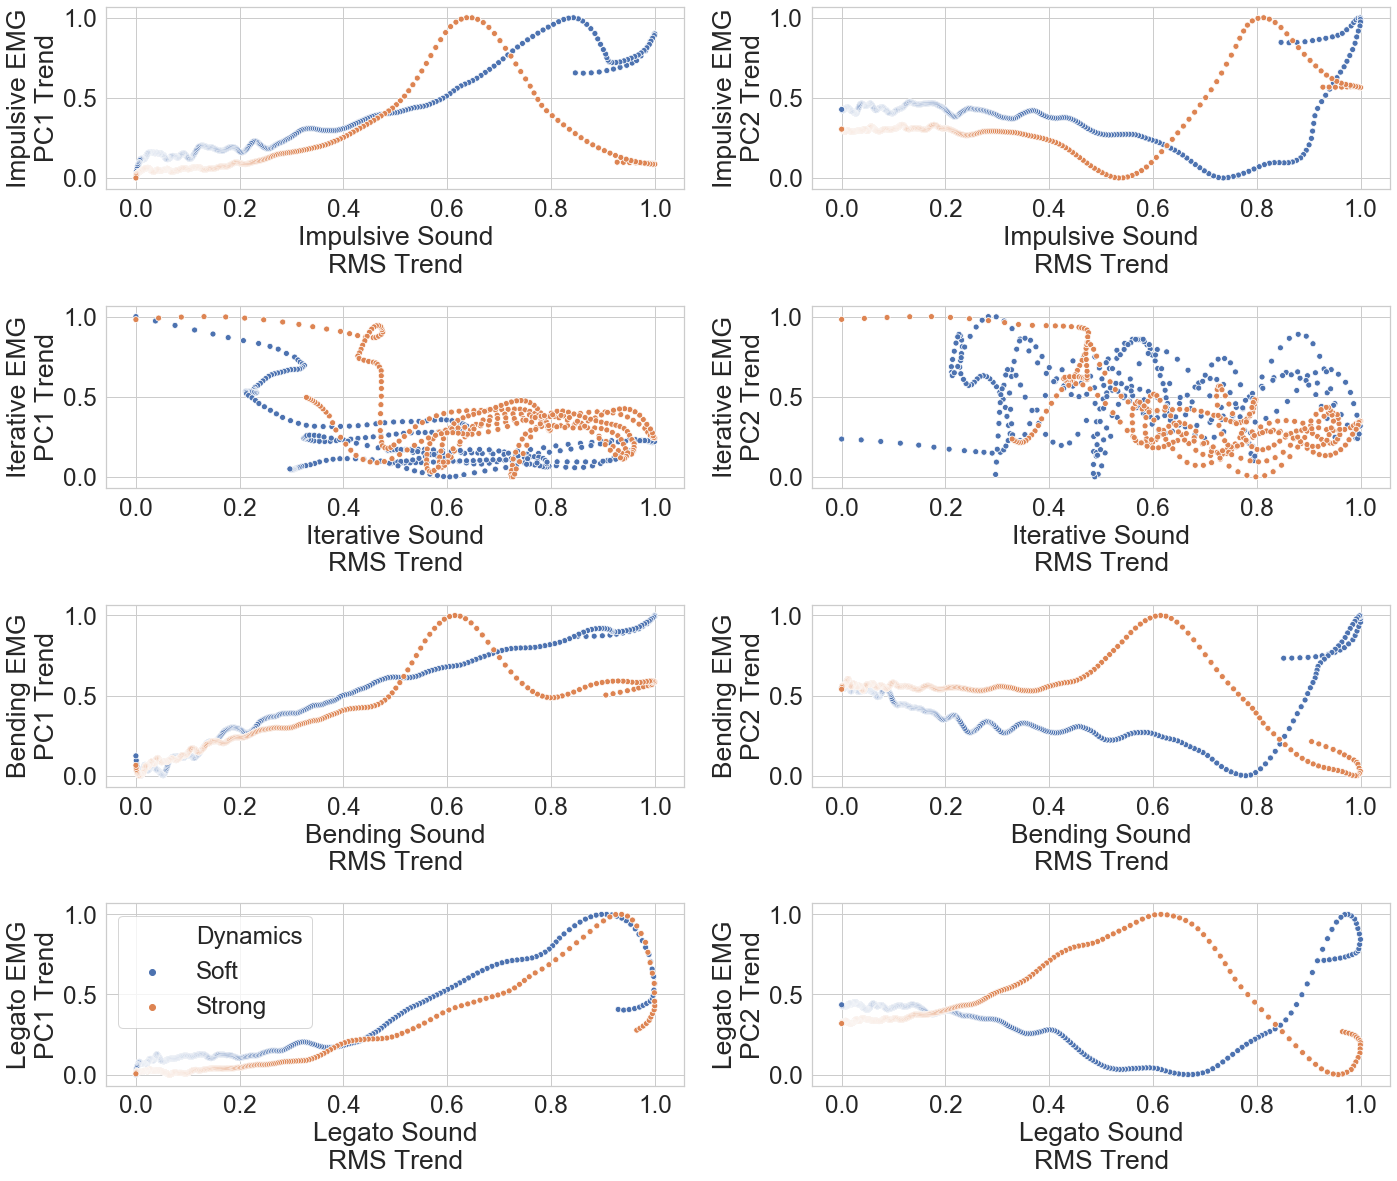

In [211]:
sns.set(style="whitegrid", font_scale=2.2)

fig, axs = plt.subplots(4,2, figsize=(20,17))
# fig.text(0.5, 0.001, 'Decomposed Sound', ha='center')
# fig.text(0.001, 0.5, 'Decomposed EMG', va='center', rotation='vertical')

window = 10   
fsize = 28

ax = sns.scatterplot(x="Sound Trend", y="EMG PC1 Trend", hue="Dynamics", data=sns_tprep('sustained',1, window, 
                      norm=True), ax=axs[0,0], legend=False)
# ax.set_title('PC1', size=fsize)
ax.set_xlabel('Impulsive Sound\nRMS Trend')
ax.set_ylabel('Impulsive EMG\nPC1 Trend')
# ax.set_yticklabels([])
# ax.set_xticklabels([])

ax = sns.scatterplot(x="Sound Trend", y="EMG PC2 Trend", hue="Dynamics", data=sns_tprep('sustained',2, window, 
                     norm=True), ax=axs[0,1], legend=False)
# ax.set_title('PC2', size=fsize)
ax.set_xlabel('Impulsive Sound\nRMS Trend')
ax.set_ylabel('Impulsive EMG\nPC2 Trend')
# ax.set_yticklabels([])
# ax.set_xticklabels([])

ax = sns.scatterplot(x="Sound Trend", y="EMG PC1 Trend", hue="Dynamics", data=sns_tprep('iterative',1, window, 
                     norm=True),ax=axs[1,0], legend=False)
ax.set_xlabel('Iterative Sound\nRMS Trend')
ax.set_ylabel('Iterative EMG\nPC1 Trend')
# ax.set_yticklabels([])
# ax.set_xticklabels([])

ax = sns.scatterplot(x="Sound Trend", y="EMG PC2 Trend", hue="Dynamics", data=sns_tprep('iterative',2, window, 
                    norm=True), ax=axs[1,1], legend=False)
ax.set_xlabel('Iterative Sound\nRMS Trend')
ax.set_ylabel('Iterative EMG\nPC2 Trend')
# ax.set_yticklabels([])
# ax.set_xticklabels([])

ax = sns.scatterplot(x="Sound Trend", y="EMG PC1 Trend", hue="Dynamics", data=sns_tprep('bending',1, window, 
                      norm=True), ax=axs[2,0], legend=False)
ax.set_xlabel('Bending Sound\nRMS Trend')
ax.set_ylabel('Bending EMG\nPC1 Trend')
# ax.set_yticklabels([])
# ax.set_xticklabels([])

ax = sns.scatterplot(x="Sound Trend", y="EMG PC2 Trend", hue="Dynamics", data=sns_tprep('bending',2, window, 
                     norm=True), ax=axs[2,1], legend=False)
ax.set_xlabel('Bending Sound\nRMS Trend')
ax.set_ylabel('Bending EMG\nPC2 Trend')
# ax.set_yticklabels([])
# ax.set_xticklabels([])

ax = sns.scatterplot(x="Sound Trend", y="EMG PC1 Trend", hue="Dynamics", data=sns_tprep('on-off',1, window, 
                      norm=True), ax=axs[3,0])
ax.set_xlabel('Legato Sound\nRMS Trend')
ax.set_ylabel('Legato EMG\nPC1 Trend')

ax.legend(loc='upper left', framealpha=0.001)
ax.legend()
# ax.set_yticklabels([])
# ax.set_xticklabels([])


ax = sns.scatterplot(x="Sound Trend", y="EMG PC2 Trend", hue="Dynamics", data=sns_tprep('on-off',2, window, 
                    norm=True), ax=axs[3,1], legend=False)
ax.set_xlabel('Legato Sound\nRMS Trend')
ax.set_ylabel('Legato EMG\nPC2 Trend')
# ax.set_yticklabels([])
# ax.set_xticklabels([])


fig.tight_layout()

# plt.savefig(os.path.join(p_path, "pc_scatter.png"), bbox_inches='tight')
plt.show()

In [44]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# sns_tprep('on-off',2, window)

In [45]:
# snd_stacks=[]
# for p in participant:

#     dfs = allof[p]['snd']['sustained_strong']
#     dfsn = pd.DataFrame(dfs)

#     snd_stacks.append(dfsn)
# snd_stacks = pd.concat(snd_stacks, axis=1)
# sound_pca = pca(snd_stacks.dropna(), 2)
# plt.plot(sound_pca)

In [46]:
# pc of 4 emg chs vs sound rms
from scipy.stats import pearsonr, spearmanr, kendalltau
# print('PearsonrResult',pearsonr(np.concatenate(deneme_pca), rms_inter_test))
# print(spearmanr(np.concatenate(deneme_pca), rms_inter_test))

In [47]:
from scipy.stats import linregress
# linregress(np.concatenate(deneme_pca), rms_inter_test)

In [48]:
#EEUCLIDIAN DISTANCE!

# from scipy.spatial import distance
# dst = distance.euclidean(x,y)
# print('Euclidean distance: %.3f' % dst)

In [49]:
#replace value 0's. a bit cheating, but not that much;) 

for t in tasks:
    allof['p19']['emg'][t[:-3]]['ch2'] = allof['p20']['emg'][t[:-3]]['ch2']
allof['p26']['emg']['bending_soft']['ch2'] = allof['p27']['emg']['bending_soft']['ch2']
allof['p15']['emg']['bending_strong']['ch2'] = allof['p14']['emg']['bending_strong']['ch2']

In [50]:
#WRITE A FUNCTION THAT RETURNS THE SCATTER PLOT DATA!
#Heat map of cross correlation coefficients (pearson) of emg (pc) vs sound rms 

import seaborn as sns

meanfq=10

r_all_pc=[]
p_all_pc=[]
p_all_pc2=[]
all_plots=[]
for p in participant:
    r_tasks=[]
    p_tasks=[]
    p_tasks2=[]
    plots=[]
    for t in tasks:
        d1_pc = pca(allof[p]['emg'][t[:-3]])
        d1_pc_df = pd.DataFrame(data=d1_pc)
        d1_pc_df_dec = decompose(d1_pc_df, meanfq)[0]
        d1_pc_fin = np.concatenate(np.array(d1_pc_df_dec))
        d1_norm = norm(d1_pc_fin)
        
        d2_df = pd.DataFrame(data=allof[p]['rms'][t[:-3]])
        d2_df_dec = decompose(d2_df, meanfq)[0]
        d2_fin = np.concatenate(np.array(d2_df_dec))
        d2_norm = norm(d2_fin)
        d2_norm_inter = interp_two(d2_norm, d1_norm)
        
        scat_plots = [d1_norm,d2_norm_inter]
        plots.append(scat_plots)
    
        r_val = pearsonr(d1_norm, d2_norm_inter)  
        
        r_tasks.append(round(r_val[0], 2))
        p_tasks2.append(r_val[1])
        if r_val[1] < 0.001:
            p_val = 'p <.001'
            p_tasks.append(p_val)
        else:
            p_tasks.append(round(r_val[1], 3))
    
    all_plots.append(plots)
    r_all_pc.append(r_tasks)
    p_all_pc.append(p_tasks)
    p_all_pc2.append(p_tasks2)
    
all_plots = all_plots
r_all_pc = pd.DataFrame(data=r_all_pc)
p_all_pc = pd.DataFrame(data=p_all_pc)
p_all_pc2 = pd.DataFrame(data=p_all_pc2)
r_all_pc.columns = [t[:-3] for t in tasks]
r_all_pc.index = [p for p in participant]

# ptext_pc = np.asarray(p_all_pc)
# plt.figure(figsize=(20,10))
# cmap = sns.diverging_palette(40, 25, sep=15, as_cmap=True, l=65, n=9)
# sns.heatmap(r_all_pc, annot=ptext_pc, fmt='', cmap=cmap)
# sns.heatmap(r_all_pc, annot=ptext_pc, fmt='', cmap=sns.color_palette("RdBu_r", 130, desat=0.85), vmin=-1, vmax=1)

# plt.savefig(os.path.join(p_path, "emg_pc_sound_rms_ccc_pearson.pdf"), bbox_inches='tight')

In [51]:
def mean_of_all_dec(task, data, meanfq=30):
    '''return the mean array of the same DECOMPOSED task accross all participants'''
    
    concat=[]
    for idx, p in enumerate(participant):
     
        dfe = pca(allof[p]['emg'][task])
        d1_pc_df = pd.DataFrame(data=dfe)
        d1_pc_df_dec = decompose(d1_pc_df, meanfq)[0]
        d1_pc_fin = np.concatenate(np.array(d1_pc_df_dec))
        d1_norm = norm(d1_pc_fin) 
        dfe=pd.DataFrame(d1_norm)
        dfe.columns = ["emg_mean"]     
    
    
        df = allof[p]['rms'][task]
        d2_df_dec = decompose(df, meanfq)[0]
        d2_fin = d2_df_dec.values
        d2_norm = norm(d2_fin)
        d2_norm_inter = interp_two(d2_norm, d1_norm)
        df=pd.DataFrame(d2_norm_inter)
        df.columns = ["rms_mean"]
        
        if data == 'emg':
            concat.append(dfe)
        else:
            concat.append(df)
    
    concat = pd.concat(concat)
    by_row_index = concat.groupby(concat.index)
    df_means = by_row_index.mean()
    
    return df_means


def sns_mprep(task, meanfq=30):
    '''Return prepared data frame for sns plot'''
    
    arrlen = len(mean_of_all_dec(task+'_soft', 'emg', meanfq))
    ts = tasks.index(task+'_soft_70')
    tS = tasks.index(task+'_strong_70')
    
    softmean = pd.concat([mean_of_all_dec(task+'_soft', 'emg', meanfq), 
                          mean_of_all_dec(task+'_soft', 'rms', meanfq), 
                          pd.DataFrame(arrlen*[dsplit(tasks[ts])[0]]),
                          pd.DataFrame(arrlen*[dsplit(tasks[ts])[1]])], 
                          axis=1)
    
    strongmean = pd.concat([mean_of_all_dec(task+'_strong', 'emg', meanfq), 
                            mean_of_all_dec(task+'_strong', 'rms', meanfq), 
                            pd.DataFrame(arrlen*[dsplit(tasks[tS])[0]]),
                            pd.DataFrame(arrlen*[dsplit(tasks[tS])[1]])], 
                            axis=1)
    
    finalemean = pd.concat([softmean, strongmean], axis=0)
    finalemean = finalemean.reset_index(drop=True)
    finalemean.columns = ['EMG PC', 'Sound RMS', 'Task', 'Dynamics']
    
    return finalemean

In [52]:
# sns_mprep('iterative', 10)

In [53]:
tnr = 6

print('mean r: ', round(np.mean([r_all_pc.iloc[tnr].mean(),r_all_pc.iloc[tnr+1].mean()]), 2))
print('mean p: ', round(np.mean([p_all_pc2.iloc[tnr].mean(),p_all_pc2.iloc[tnr+1].mean()]), 2))

mean r:  0.2
mean p:  0.05


In [54]:
# sns.set(style="white", font_scale=2.3)

# fig, axs = plt.subplots(2,2, figsize=(15,10))

# meanfq = 10    
# fsize = 28

# ax = sns.scatterplot(x="Sound RMS", y="EMG PC", hue="Dynamics", data=sns_mprep('sustained', meanfq), 
#                      ax=axs[0,0])
# ax.set_title('Sustained (r: 0.43, p-val: 0.07)', size=fsize)
# ax.set_xlabel('')
# ax.set_yticklabels([])
# ax.set_xticklabels([])

# ax = sns.scatterplot(x="Sound RMS", y="EMG PC", hue="Dynamics", data=sns_mprep('iterative', meanfq), 
#                      ax=axs[0,1], legend=False)
# ax.set_title('Iterative (r: 0.21, p-val: 0.05)', size=fsize)
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_yticklabels([])
# ax.set_xticklabels([])

# ax = sns.scatterplot(x="Sound RMS", y="EMG PC", hue="Dynamics", data=sns_mprep('bending', meanfq), 
#                      ax=axs[1,0], legend=False)
# ax.set_title('Bending (r: 0.3, p-val: 0.08)', size=fsize)
# ax.set_yticklabels([])
# ax.set_xticklabels([])

# ax = sns.scatterplot(x="Sound RMS", y="EMG PC", hue="Dynamics", data=sns_mprep('on-off', meanfq), 
#                      ax=axs[1,1], legend=False)
# ax.set_title('Hammer-on & Pull-off (r: 0.46, p-val: 0.01)', size=fsize)
# ax.set_ylabel('')
# ax.set_yticklabels([])
# ax.set_xticklabels([])


# plt.tight_layout()

# # plt.savefig(os.path.join(p_path, "mean_scatter.pdf"), bbox_inches='tight')

In [55]:
def talign(people):
    '''Return an aligned array towards sns plot'''
    
    p = participant.index(people)
    
    hmm=[]
    for t in range(8):

        emg = all_plots[p][t][0]
        sound = all_plots[p][t][1]
        participants = len(all_plots[p][t][0])*[participant[p]]
        taskz = len(all_plots[p][t][0])*[dsplit(tasks[t])[0]]
        dynamics = len(all_plots[p][t][0])*[dsplit(tasks[t])[1]]

        hmm.append([emg,sound,participants,taskz,dynamics])
    hmm_df=np.concatenate(hmm, axis=1).transpose()
    
#     hmm_df=pd.DataFrame(hmm_df)
#     hmm_df.columns= ['EMG', 'Sound RMS', 'Participant', 'Task', 'Dynamics']
    
    return hmm_df

#Do it for all participants
hmmp=[]
for p in participant:  
    hmmp.append(talign(p))
hmmp_df=np.concatenate(hmmp, axis=0)
allp=pd.DataFrame(hmmp_df)
allp.columns= ['EMG', 'Sound RMS', 'Participant', 'Task', 'Dynamics']

In [56]:
def pearson_all(channel):
    '''Return Pearson linear correlation coefficients (LCC) and p-values of EMG channels vs sound rms.'''
    
    ch = 'ch'+str(channel)
    
    r_all_ch1=[]
    p_all_ch1=[]
    for p in participant:
        r_tasks=[]
        p_tasks=[]
        for t in tasks:
            d1_df = allof[p]['emg'][t[:-3]][ch]
            d1_norm = norm(d1_df.values)

            d2_df = allof[p]['rms'][t[:-3]]
            d2_norm = norm(d2_df.values)
            d2_norm_inter = interp_two(d2_norm, d1_norm)

            r_val1 = pearsonr(d1_norm, d2_norm_inter)  
            r_tasks.append(round(r_val1[0], 2))
            p_tasks.append(r_val1[1])

        r_all_ch1.append(r_tasks)
        p_all_ch1.append(p_tasks)
        
    r_all_ch1 = pd.DataFrame(data=r_all_ch1)
    r_all_ch1.columns = [t[:-3] for t in tasks]
    r_all_ch1.index = [p for p in participant]
    
    p_all_ch1 = pd.DataFrame(data=p_all_ch1)
    p_all_ch1.columns = [t[:-3] for t in tasks]
    p_all_ch1.index = [p for p in participant]
    
    return r_all_ch1, p_all_ch1

In [57]:
# pearson_all(1)[1]

In [58]:
from scipy.spatial import distance
dst = distance.euclidean(allof['p01']['emg']['sustained_strong'].ch1, 
                         interp_two(allof['p01']['rms']['sustained_strong'], allof['p01']['emg']['sustained_strong'].ch1))
dst

4.906918601971294

In [59]:
#EEUCLIDIAN DISTANCE!

# from scipy.spatial import distance
# dst = distance.euclidean(x,y)
# print('Euclidean distance: %.3f' % dst)

In [60]:
from scipy.spatial import distance

def euclidean_all(channel):
    
    '''Return all euclidian distances of emg channels vs sound rms '''
    ch = 'ch'+str(channel)

    r2_all_ch1=[]
    for p in participant:
        r_tasks=[]
        for t in tasks:

            d1_df = pd.DataFrame(data=allof[p]['emg'][t[:-3]][ch])
            d1_norm = norm(d1_df.values)

            d2_df = allof[p]['rms'][t[:-3]]
            d2_norm = norm(d2_df.values)
            d2_norm_inter = interp_two(d2_norm, d1_norm)

            r_val1 = distance.euclidean(d1_norm, d2_norm_inter) 
            r_tasks.append(round(r_val1, 2))

        r2_all_ch1.append(r_tasks)


    r2_all_ch1 = pd.DataFrame(data=r2_all_ch1)
    r2_all_ch1.columns = [t[:-3] for t in tasks]
    r2_all_ch1.index = [p for p in participant]
    
    return r2_all_ch1

def sns_prep_euc(data, ch):

    channels = ['Extensor (R)', 'Flexor (R)', 'Extensor (L)', 'Flexor (L)']
    boxall=[]
    for i, t in enumerate(tasks):
        tval = pd.DataFrame(data.iloc[:,i].values)
        tlen = len(data.iloc[:,i].values)
        tname = pd.DataFrame(tlen*[t.split("_", 1)[0].capitalize()])
        pname = pd.DataFrame([p for p in participant])
        finale = pd.concat([pname,tval,tname],axis=1)
        boxall.append(finale)

    channel = pd.DataFrame(31*[channels[ch-1]]*8)
    dynamics = pd.DataFrame((31*['Soft'] + 31*['Strong']) *4)
    boxall=pd.concat([boxall[0],boxall[1],boxall[2],boxall[3],boxall[4],boxall[5],boxall[6],boxall[7]], axis=0)
    boxall = boxall.reset_index(drop=True)
    boxall=pd.concat([boxall,dynamics, channel], axis=1)
    boxall.columns=['Participant', 'Euclidian Distance','Tasks', 'Dynamics', 'Channel']
    
    return boxall

In [61]:
# euclidean_all(1)

In [62]:
sns_euclidian_all = pd.concat([sns_prep_euc(euclidean_all(3), 3), 
                              sns_prep_euc(euclidean_all(4), 4),
                              sns_prep_euc(euclidean_all(1), 1),
                              sns_prep_euc(euclidean_all(2), 2),], axis=0)

sns_euclidian_all['Tasks'] = sns_euclidian_all['Tasks'].str.replace('Sustained','Impulsive')

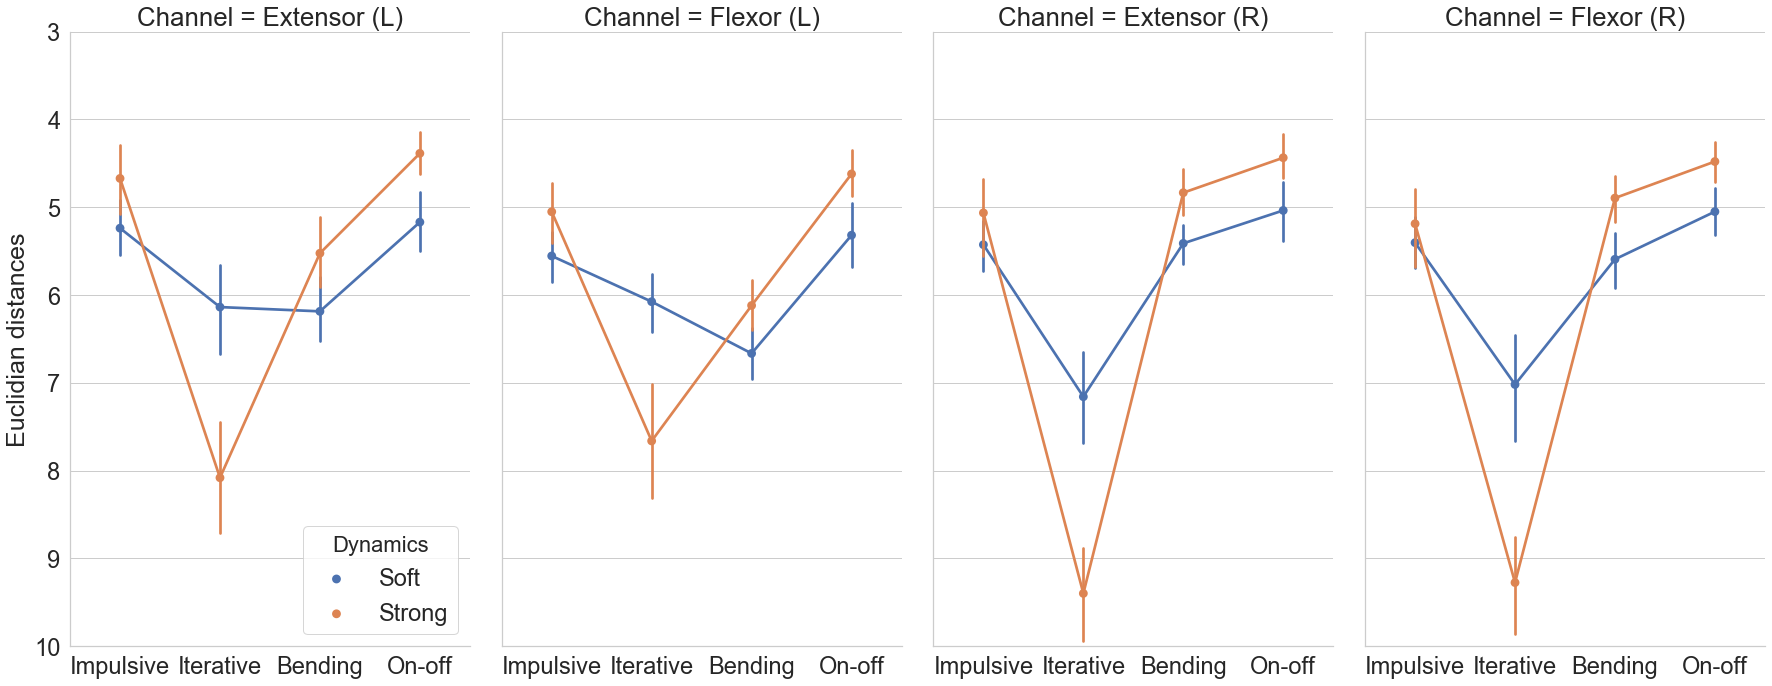

In [63]:
sns.set(style="whitegrid", font_scale=2.15)

eucbox = sns.catplot(x='Tasks', y='Euclidian Distance', hue='Dynamics',col="Channel", data=sns_euclidian_all,
                kind="point", saturation=1, 
                height=10.5, aspect=0.6, legend_out=False, sharey=True, sharex=True,
                order=["Impulsive", "Iterative", "Bending", "On-off"])
# palette="autumn",
# boxprops=dict(alpha=0.8),

for i in range(4):
    eucbox.axes[0,i].set_xlabel('')

eucbox.set_ylabels("Euclidian distances", fontsize=25)
# ax.set_axis_labels('Tasks')
eucbox.set(ylim=(10,3))

# limite = eucbox.axes
# limite.set_ylim(reversed(plt.ylim()))


# plt.savefig(os.path.join(p_path, "euclidian_all_boxplots.png"), bbox_inches='tight')

In [64]:
sns_euclidian_all.head()

,Participant,Euclidian Distance,Tasks,Dynamics,Channel
0,p01,6.79,Bending,Soft,Extensor (L)
1,p02,6.91,Bending,Soft,Extensor (L)
2,p03,5.28,Bending,Soft,Extensor (L)
3,p04,6.98,Bending,Soft,Extensor (L)
4,p05,6.96,Bending,Soft,Extensor (L)


In [65]:
# euclidian_all(1)

In [66]:
# aov = pg.rm_anova(data=anova_df, subject='Participant', within= ['Euclidian Distance', 'LCC', 'SCC'],
#                       detailed=True)
# print(aov)

In [67]:
def spearman_all(channel):
    '''Return all cross correlation coefficients (spearman) of emg channels vs sound rms '''
    ch = 'ch'+str(channel)
        
    r2_all_ch1=[]
    p2_all_ch1=[]
    p2ch_all_ch1=[]
    for p in participant:
        r_tasks=[]
        p_tasks=[]
        p_tasks2ch=[]
        for t in tasks:

            d1_df = pd.DataFrame(data=allof[p]['emg'][t[:-3]][ch])
            d1_norm = norm(d1_df.values)

            d2_df = allof[p]['rms'][t[:-3]]
            d2_norm = norm(d2_df.values)
            d2_norm_inter = interp_two(d2_norm, d1_norm)

            r_val1 = spearmanr(d1_norm, d2_norm_inter) 
            r_tasks.append(round(r_val1[0], 2))
            p_tasks2ch.append(r_val1[1])

            if r_val1[1] < 0.0001:
                p_val = '<.001'
                p_tasks.append(p_val)
            else:
                p_tasks.append(round(r_val1[1], 3))
        r2_all_ch1.append(r_tasks)
        p2_all_ch1.append(p_tasks)
        p2ch_all_ch1.append(p_tasks2ch)

    r2_all_ch1 = pd.DataFrame(data=r2_all_ch1)
    p2_all_ch1 = pd.DataFrame(data=p2_all_ch1)
    p2ch_all_ch1 = pd.DataFrame(data=p2ch_all_ch1)

    r2_all_ch1.columns = [t[:-3] for t in tasks]
    r2_all_ch1.index = [p for p in participant]

    p2ch_all_ch1.columns = [t[:-3] for t in tasks]
    p2ch_all_ch1.index = [p for p in participant]
    
    return r2_all_ch1, p2ch_all_ch1

In [68]:
# participant

In [69]:
# plt.figure(figsize=(20,10))
# sns.heatmap(spearman_all(1)[0], annot=None, fmt='', 
#             cmap=sns.color_palette("RdBu_r", 130, desat=0.85), vmin=-1, vmax=1)

In [133]:
#plot prep for corr
def sns_prep(data, ch):

    channels = ['Extensor (right)', 'Flexor (right)', 'Extensor (left)', 'Flexor (left)']
    boxall=[]
    for i, t in enumerate(tasks):
        tval = pd.DataFrame(data.iloc[:,i].values)
        tlen = len(data.iloc[:,i].values)
        tname = pd.DataFrame(tlen*[t.split("_", 1)[0].capitalize()])
        pname = pd.DataFrame([p for p in participant])
        finale = pd.concat([pname,tval,tname],axis=1)
        boxall.append(finale)

    channel = pd.DataFrame(31*[channels[ch-1]]*8)
    dynamics = pd.DataFrame((31*['Soft'] + 31*['Strong']) *4)
    boxall=pd.concat([boxall[0],boxall[1],boxall[2],boxall[3],boxall[4],boxall[5],boxall[6],boxall[7]], axis=0)
    boxall = boxall.reset_index(drop=True)
    boxall=pd.concat([boxall,dynamics, channel], axis=1)
    boxall.columns=['Participant', 'SCC','Tasks', 'Dynamics', 'Channel']
    
    return boxall


#plot prep for corr p-vals
def sns_prep_p(data, ch):

    channels = ['Extensor (right)', 'Flexor (right)', 'Extensor (left)', 'Flexor (left)']
    boxall=[]
    for i, t in enumerate(tasks):
        tval = pd.DataFrame(data.iloc[:,i].values)
        tlen = len(data.iloc[:,i].values)
        tname = pd.DataFrame(tlen*[t.split("_", 1)[0].capitalize()])
        pname = pd.DataFrame([p for p in participant])
        finale = pd.concat([pname,tval,tname],axis=1)
        boxall.append(finale)

    channel = pd.DataFrame(31*[channels[ch-1]]*8)
    dynamics = pd.DataFrame((31*['Soft'] + 31*['Strong']) *4)
    boxall=pd.concat([boxall[0],boxall[1],boxall[2],boxall[3],boxall[4],boxall[5],boxall[6],boxall[7]], axis=0)
    boxall = boxall.reset_index(drop=True)
    boxall=pd.concat([boxall,dynamics, channel], axis=1)
    boxall.columns=['Participant', 'p-value','Tasks', 'Dynamics', 'Channel']
    
    return boxall

#### Pearson coeffs

In [71]:
#GIVE MAX OR MIN VALUES IN THE ORDER OF TASKS - pearson
neworder = [4,5,6,7,0,1,2,3]
taskso = [tasks[i] for i in neworder]

for i,t in enumerate(taskso):
    vals = pearson_all(4)[0].idxmin()
    res = pearson_all(4)[0].loc[vals.values[i], :].min()
    print(res, t)

-0.63 sustained_soft_70
-0.62 sustained_strong_70
-0.53 iterative_soft_70
-0.51 iterative_strong_70
-0.54 bending_soft_70
-0.46 bending_strong_70
-0.3 on-off_soft_70
-0.53 on-off_strong_70


In [72]:
#Mean
for i, t in enumerate(taskso):
    print(t, 'Mean r: ', round(pearson_all(4)[0].iloc[:,i].mean(), 2))

sustained_soft_70 Mean r:  -0.34
sustained_strong_70 Mean r:  -0.24
iterative_soft_70 Mean r:  0.2
iterative_strong_70 Mean r:  0.21
bending_soft_70 Mean r:  0.03
bending_strong_70 Mean r:  0.15
on-off_soft_70 Mean r:  -0.01
on-off_strong_70 Mean r:  -0.02


In [73]:
#Standard deviation
for i, t in enumerate(taskso):
    print(t, 'STD r: ', round(pearson_all(4)[0].iloc[:,i].std(), 2))

sustained_soft_70 STD r:  0.28
sustained_strong_70 STD r:  0.25
iterative_soft_70 STD r:  0.28
iterative_strong_70 STD r:  0.2
bending_soft_70 STD r:  0.14
bending_strong_70 STD r:  0.22
on-off_soft_70 STD r:  0.14
on-off_strong_70 STD r:  0.12


#### Spearman coeffs

In [74]:
#GIVE MAX OR MIN VALUES IN THE ORDER OF TASKS - spearman
for i,t in enumerate(taskso):
    vals = spearman_all(4)[0].idxmin()
    res = spearman_all(4)[0].loc[vals.values[i], :].min()
    print(res, t)

-0.77 sustained_soft_70
-0.78 sustained_strong_70
-0.5 iterative_soft_70
-0.5 iterative_strong_70
-0.62 bending_soft_70
-0.78 bending_strong_70
-0.55 on-off_soft_70
-0.61 on-off_strong_70


In [75]:
#Mean
for i, t in enumerate(taskso):
    print(t, 'Mean r: ', round(spearman_all(4)[0].iloc[:,i].mean(), 2))

sustained_soft_70 Mean r:  -0.38
sustained_strong_70 Mean r:  -0.26
iterative_soft_70 Mean r:  0.21
iterative_strong_70 Mean r:  0.29
bending_soft_70 Mean r:  0.04
bending_strong_70 Mean r:  0.17
on-off_soft_70 Mean r:  -0.0
on-off_strong_70 Mean r:  -0.0


In [76]:
#Standard deviation
for i, t in enumerate(taskso):
    print(t, 'STD r: ', round(spearman_all(4)[0].iloc[:,i].std(), 2))

sustained_soft_70 STD r:  0.31
sustained_strong_70 STD r:  0.31
iterative_soft_70 STD r:  0.31
iterative_strong_70 STD r:  0.23
bending_soft_70 STD r:  0.16
bending_strong_70 STD r:  0.26
on-off_soft_70 STD r:  0.13
on-off_strong_70 STD r:  0.1


In [77]:
(4.5 * 60) * 100 / 60 / 60

7.5

In [78]:
spearman_all(2)[0]

,bending_soft,bending_strong,on-off_soft,on-off_strong,sustained_soft,sustained_strong,iterative_soft,iterative_strong
p01,0.19,0.25,0.48,0.47,-0.03,0.63,-0.12,-0.11
p02,-0.22,0.03,0.01,0.24,0.02,0.21,-0.11,0.24
p03,0.38,0.54,0.47,0.41,0.18,0.71,0.00,-0.13
p04,0.38,0.47,-0.15,0.37,0.27,0.32,0.16,-0.28
p05,0.44,0.35,0.19,0.49,-0.01,0.12,-0.04,0.18
p06,0.01,0.23,0.36,0.08,-0.04,-0.12,-0.19,0.20
p07,0.07,-0.04,0.23,0.56,-0.11,0.30,0.08,-0.26
p08,-0.04,0.40,0.30,0.04,0.20,0.44,0.07,0.12
p09,0.33,0.42,0.11,0.38,0.22,0.47,-0.15,0.01
p10,0.32,0.33,0.13,0.17,0.19,0.58,0.01,0.13


In [79]:
# sns_prep(spearman_all(1)[0].abs(), 1)

In [80]:
# #replace single nan values

# edt_spearman2 = spearman_all(2)[0]
# edt_spearman2['bending_strong'][14] = spearman_all(2)[0]['bending_strong'][13]

# edt_spearman2p = spearman_all(2)[1]
# edt_spearman2p['bending_strong'][14] = spearman_all(2)[1]['bending_strong'][13]

In [131]:
sns_spearman_all.head()

,Participant,SCC,Tasks,Dynamics,Channel
0,p01,-0.41,T3,Soft,Extensor (L)
1,p02,-0.32,T3,Soft,Extensor (L)
2,p03,-0.07,T3,Soft,Extensor (L)
3,p04,-0.50,T3,Soft,Extensor (L)
4,p05,-0.54,T3,Soft,Extensor (L)


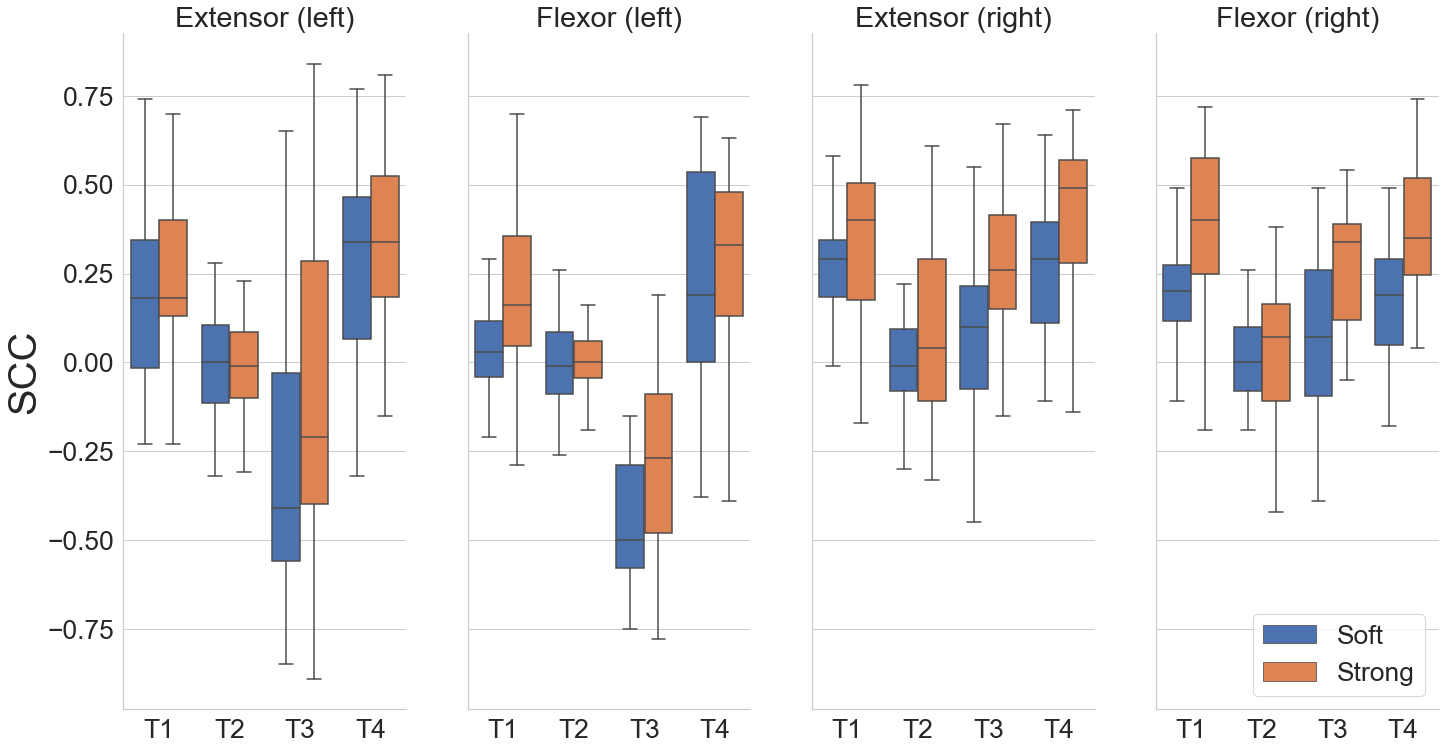

In [213]:
# -1 TO 1 RANGE

sns_spearman_all = pd.concat([sns_prep(spearman_all(3)[0], 3), 
                              sns_prep(spearman_all(4)[0], 4),
                              sns_prep(spearman_all(1)[0], 1),
                              sns_prep(spearman_all(2)[0], 2),], axis=0)

sns_spearman_all['Tasks'] = sns_spearman_all['Tasks'].str.replace('Sustained','T1')
sns_spearman_all['Tasks'] = sns_spearman_all['Tasks'].str.replace('Iterative','T2')
sns_spearman_all['Tasks'] = sns_spearman_all['Tasks'].str.replace('Bending','T3')
sns_spearman_all['Tasks'] = sns_spearman_all['Tasks'].str.replace('On-off','T4')
# T1, T2, T3 and T4 refer to Impulsive, Iterative, Bending and Legato, respectively. 

sns.set(style="whitegrid", font_scale=2.4)

sbox = sns.catplot(x='Tasks', y='SCC', hue='Dynamics',col="Channel", data=sns_spearman_all,
                kind="box", saturation=1, fliersize=5, legend=False,
                height=11.5, aspect=0.45, legend_out=False, sharey=True, sharex=True, showfliers = False, 
                order=["T1", "T2", "T3", "T4"])

sbox.set_titles(col_template = '{col_name}')
# sbox.set_xticklabels(rotation=45)
# palette="autumn",
# boxprops=dict(alpha=0.8),

for i in range(4):
    sbox.axes[0,i].set_xlabel('')

sbox.set_ylabels("SCC", fontsize=40)
plt.legend(loc='lower right')
# ax.set_axis_labels('Tasks')


# plt.savefig(os.path.join(p_path, "spearman_all_boxplots.png"), bbox_inches='tight')

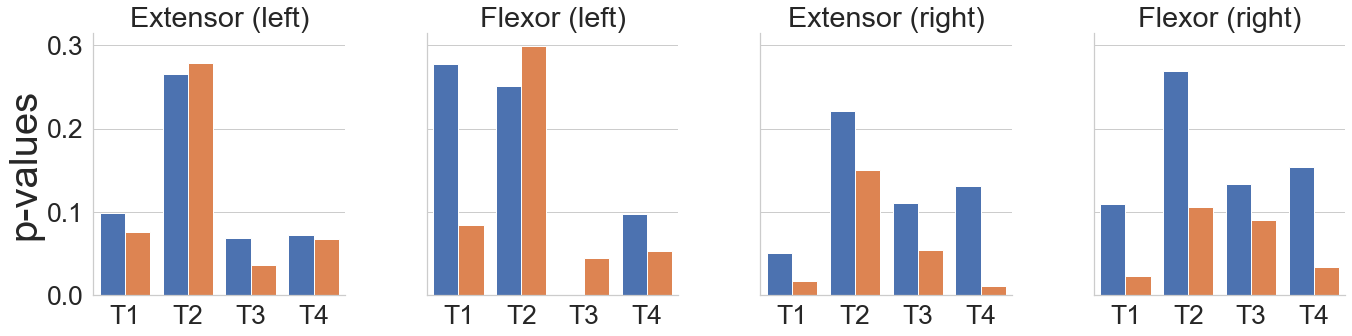

In [228]:
sns_spearman_p_all = pd.concat([sns_prep_p(spearman_all(3)[1], 3), 
                                sns_prep_p(spearman_all(4)[1], 4),
                                sns_prep_p(spearman_all(1)[1], 1),
                                sns_prep_p(spearman_all(2)[1], 2),], axis=0)

# sns_spearman_p_all['Tasks'] = sns_spearman_p_all['Tasks'].str.replace('Sustained','Impulsive')

sns_spearman_p_all['Tasks'] = sns_spearman_p_all['Tasks'].str.replace('Sustained','T1')
sns_spearman_p_all['Tasks'] = sns_spearman_p_all['Tasks'].str.replace('Iterative','T2')
sns_spearman_p_all['Tasks'] = sns_spearman_p_all['Tasks'].str.replace('Bending','T3')
sns_spearman_p_all['Tasks'] = sns_spearman_p_all['Tasks'].str.replace('On-off','T4')


sbarp = sns.catplot(x='Tasks', y='p-value', hue='Dynamics',col="Channel", data=sns_spearman_p_all,
                kind="bar", saturation=1,ci=None,
                height=5.75, aspect=0.85, legend=False, sharey=True, sharex=True, 
                order=["T1", "T2", "T3", "T4"])

sbarp.set_titles(col_template = '{col_name}')

for i in range(4):
    sbarp.axes[0,i].set_xlabel('')

sbarp.set_ylabels('p-values', fontsize=40)
# sbarp.set_xticklabels('')
# sbarp.set_titles('')
# sbarp.map(plt.axhline, y=0.05, ls='--', c='red', alpha=0.3)

# ax.set_axis_labels('')

# plt.savefig(os.path.join(p_path, "spearman_all_barplots.png"), bbox_inches='tight')

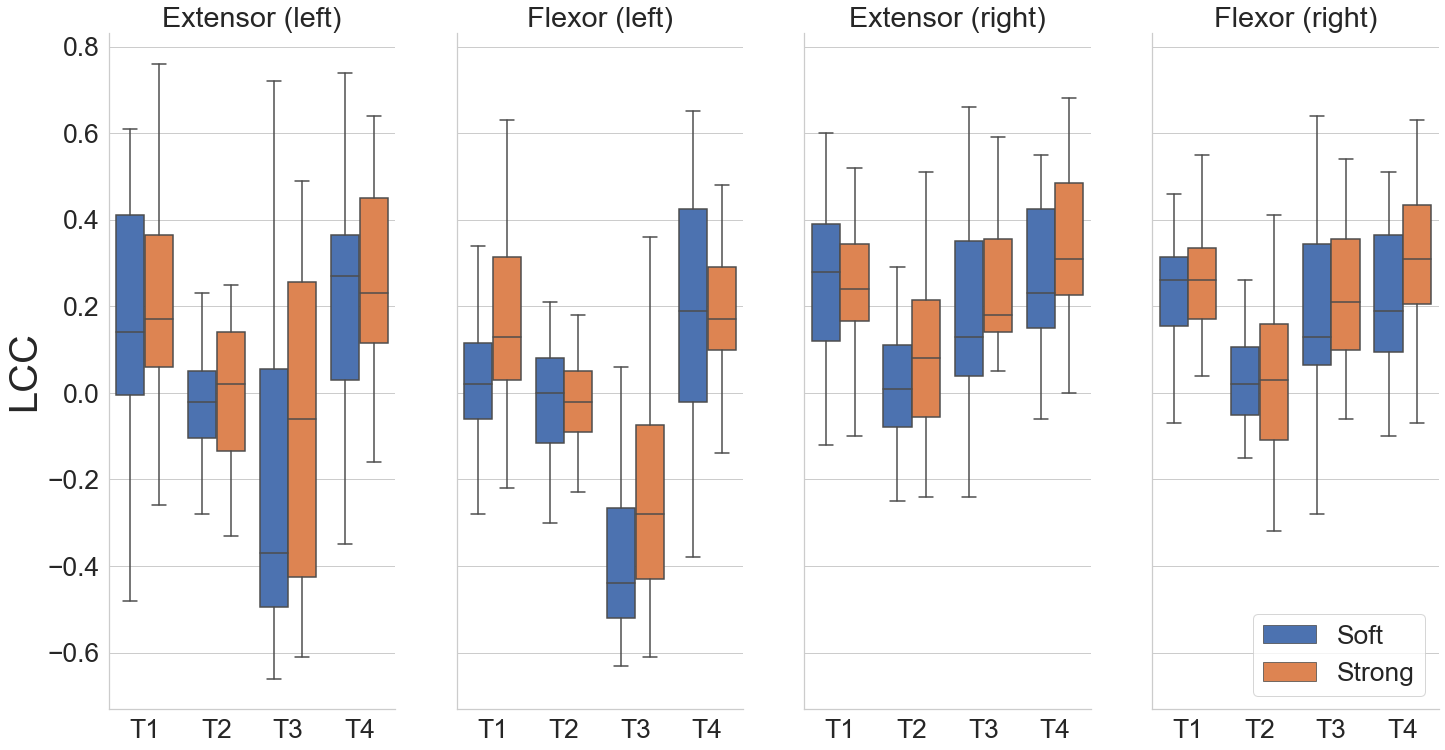

In [216]:
# Pearson -1 to 1

sns_pearson_all = pd.concat([sns_prep(pearson_all(3)[0], 3), 
                             sns_prep(pearson_all(4)[0], 4),
                             sns_prep(pearson_all(1)[0], 1),
                             sns_prep(pearson_all(2)[0], 2),], axis=0)


sns_pearson_all['Tasks'] = sns_pearson_all['Tasks'].str.replace('Sustained','T1')
sns_pearson_all['Tasks'] = sns_pearson_all['Tasks'].str.replace('Iterative','T2')
sns_pearson_all['Tasks'] = sns_pearson_all['Tasks'].str.replace('Bending','T3')
sns_pearson_all['Tasks'] = sns_pearson_all['Tasks'].str.replace('On-off','T4')
# T1, T2, T3 and T4 refer to Impulsive, Iterative, Bending and Legato, respectively. 



sns_pearson_all.columns = ['Participant', 'LCC','Tasks', 'Dynamics', 'Channel']

pbox = sns.catplot(x='Tasks', y='LCC', hue='Dynamics',col="Channel", data=sns_pearson_all,
                kind="box", saturation=1, fliersize=5, legend=False,
                height=11.5, aspect=0.45, legend_out=False, sharey=True, sharex=True, showfliers = False,
                order=["T1", "T2", "T3", "T4"])

pbox.set_titles(col_template = '{col_name}')

# boxprops=dict(alpha=0.8),

for i in range(4):
    pbox.axes[0,i].set_xlabel('')

pbox.set_ylabels("LCC", fontsize=40)
# ax.set_axis_labels('Tasks')
plt.legend(loc='lower right')

# plt.savefig(os.path.join(p_path, "pearson_all_boxplots.png"), bbox_inches='tight')

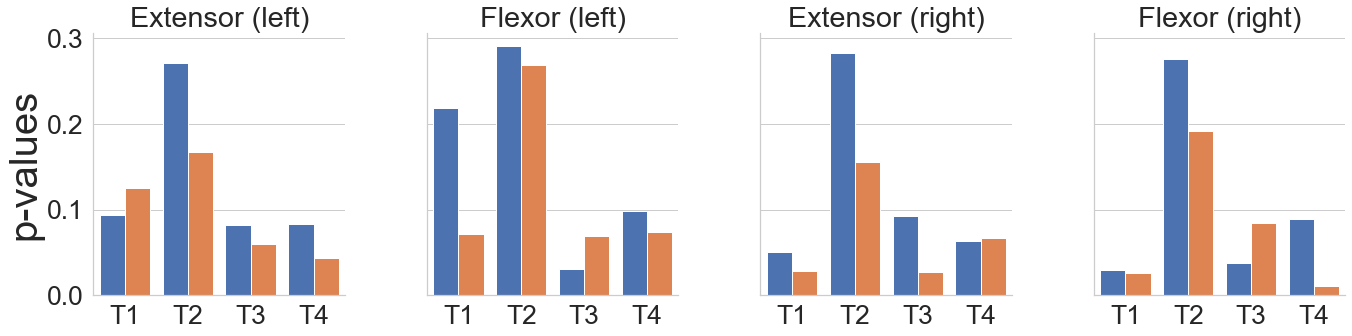

In [217]:
sns_pearson_p_all = pd.concat([sns_prep_p(pearson_all(3)[1], 3), 
                               sns_prep_p(pearson_all(4)[1], 4),
                               sns_prep_p(pearson_all(1)[1], 1),
                               sns_prep_p(pearson_all(2)[1], 2),], axis=0)


sns_pearson_p_all['Tasks'] = sns_pearson_p_all['Tasks'].str.replace('Sustained','T1')
sns_pearson_p_all['Tasks'] = sns_pearson_p_all['Tasks'].str.replace('Iterative','T2')
sns_pearson_p_all['Tasks'] = sns_pearson_p_all['Tasks'].str.replace('Bending','T3')
sns_pearson_p_all['Tasks'] = sns_pearson_p_all['Tasks'].str.replace('On-off','T4')

pbarp = sns.catplot(x='Tasks', y='p-value', hue='Dynamics',col="Channel", data=sns_pearson_p_all,
                kind="bar", saturation=1, ci=None,
                height=5.75, aspect=0.85, legend=False, sharey=True, sharex=True, 
                order=["T1", "T2", "T3", "T4"])

pbarp.set_titles(col_template = '{col_name}')

for i in range(4):
    pbarp.axes[0,i].set_xlabel('')

pbarp.set_ylabels('p-values', fontsize=40)
# pbarp.set_xticklabels('')
# pbarp.set_titles('')
# pbarp.map(plt.axhline, y=0.05, ls='--', c='red', alpha=0.3)
# ax.set_axis_labels('')

# plt.savefig(os.path.join(p_path, "pearson_all_barplots.png"), bbox_inches='tight')

In [88]:
# #Pearson absolute

# sns_pearson_all = pd.concat([sns_prep(pearson_all(3)[0].abs(), 3), 
#                              sns_prep(pearson_all(4)[0].abs(), 4),
#                              sns_prep(pearson_all(1)[0].abs(), 1),
#                              sns_prep(pearson_all(2)[0].abs(), 2),], axis=0)

# sns_pearson_all.columns = ['Participant', 'LCC','Tasks', 'Dynamics', 'Channel']

# pbox = sns.catplot(x='Tasks', y='LCC', hue='Dynamics',col="Channel", data=sns_pearson_all,
#                 kind="box", saturation=1, fliersize=5, 
#                 height=11.5, aspect=0.4, legend_out=False, sharey=True, sharex=True,
#                 order=["Sustained", "Iterative", "Bending", "On-off"])

# # boxprops=dict(alpha=0.8),

# for i in range(4):
#     pbox.axes[0,i].set_xlabel('')

# pbox.set_ylabels("Pearsons's linear correlation coefficients (LCC)", fontsize=25)
# # ax.set_axis_labels('Tasks')


# # plt.savefig(os.path.join(p_path, "pearson_all_boxplots.png"), bbox_inches='tight')

In [89]:
# sns_pearson_p_all = pd.concat([sns_prep_p(pearson_all(3)[1], 3), 
#                                sns_prep_p(pearson_all(4)[1], 4),
#                                sns_prep_p(pearson_all(1)[1], 1),
#                                sns_prep_p(pearson_all(2)[1], 2),], axis=0)

# pbarp = sns.catplot(x='Tasks', y='p-value', hue='Dynamics',col="Channel", data=sns_pearson_p_all,
#                 kind="bar", saturation=1, ci=None,
#                 height=5.75, aspect=0.8, legend=False, sharey=True, sharex=True,
#                 order=["Sustained", "Iterative", "Bending", "On-off"])

# for i in range(4):
#     pbarp.axes[0,i].set_xlabel('')

# pbarp.set_ylabels('p-values', fontsize=25)
# pbarp.set_xticklabels('')
# pbarp.set_titles('')
# # pbarp.map(plt.axhline, y=0.05, ls='--', c='red', alpha=0.3)
# # ax.set_axis_labels('')

# # plt.savefig(os.path.join(p_path, "pearson_all_barplots.png"), bbox_inches='tight')

The assumption of homogeneity of variance can be tested using tests such as Levene’s test or the Brown-Forsythe Test.  Normality of the distribution of the scores can be tested using histograms, the values of skewness and kurtosis, or using tests such as Shapiro-Wilk or Kolmogorov-Smirnov or Q-Q plot. The assumption of independence can be determined from the design of the study.

In [90]:
#ANOVAs
import pingouin as pg
anova_df = pd.concat([sns_euclidian_all, sns_pearson_all[['LCC']], sns_spearman_all[['SCC']]], axis=1)
# anova_df.head()

euclid_aov = pg.anova(data=sns_euclidian_all, dv='Euclidian Distance', between=['Participant'], 
                      detailed=True, ss_type=1)
spearman_aov = pg.anova(data=sns_spearman_all, dv='SCC', between='Participant', 
                      detailed=True, ss_type=1)
pearson_aov = pg.anova(data=sns_pearson_all, dv='LCC', between=['Participant'], 
                      detailed=True, ss_type=1)

print(euclid_aov)
print(spearman_aov)
print(pearson_aov)

        Source           SS   DF        MS         F     p-unc       np2
0  Participant    77.052434   30  2.568414  0.892241  0.634594  0.027099
1       Within  2766.344694  961  2.878611       NaN       NaN       NaN
        Source         SS   DF        MS         F     p-unc       np2
0  Participant   4.357808   30  0.145260  1.593341  0.023128  0.047383
1       Within  87.611566  961  0.091167       NaN       NaN       NaN
        Source         SS   DF        MS         F     p-unc       np2
0  Participant   3.393992   30  0.113133  1.600342  0.022087  0.047582
1       Within  67.936034  961  0.070693       NaN       NaN       NaN


In [91]:
anova_df

,Participant,Euclidian Distance,Tasks,Dynamics,Channel,LCC,SCC
0,p01,6.79,Bending,Soft,Extensor (L),-0.39,-0.41
1,p02,6.91,Bending,Soft,Extensor (L),-0.37,-0.32
2,p03,5.28,Bending,Soft,Extensor (L),0.16,-0.07
3,p04,6.98,Bending,Soft,Extensor (L),-0.47,-0.50
4,p05,6.96,Bending,Soft,Extensor (L),-0.46,-0.54
5,p06,4.69,Bending,Soft,Extensor (L),0.36,0.46
6,p07,6.23,Bending,Soft,Extensor (L),-0.32,-0.31
7,p08,7.04,Bending,Soft,Extensor (L),-0.64,-0.82
8,p09,6.00,Bending,Soft,Extensor (L),-0.55,-0.62
9,p10,5.69,Bending,Soft,Extensor (L),0.04,-0.03


In [92]:
def anova_util(p_idx, metric='SCC', soft=True,):
    
    if soft:
        dynamics = 'Soft'
    else:
        dynamics = 'Strong'
        
    peep = participant[p_idx]
    
    ps = anova_df[anova_df['Participant']== peep]
    p_dynamics = ps[ps['Dynamics']==dynamics][[metric]] 
    p_ds = p_dynamics.reset_index(drop=True).squeeze()
    
    return p_ds


def assumptions(metric):
    import scipy.stats as stats
    
    soft_var, str_var, soft_norm, str_norm = [], [], [], []
    for p in range(len(participant)):
        p_soft = anova_util(p, metric=metric, soft=True)
        p_strong = anova_util(p, metric=metric, soft=False)
        
        soft_var.append(p_soft), str_var.append(p_strong)
        
        # Shapiro-Wilk normality test 
        soft_norm.append(stats.shapiro(p_soft)), str_norm.append(stats.shapiro(p_strong))
        
    # Levene variance test 
    soft_var = stats.levene(*soft_var)
    str_var = stats.levene(*str_var)
    
    return soft_var, str_var, soft_norm, str_norm

In [93]:
# assumptions('Euclidian Distance')[3]

In [94]:
# for i in range(len(participant)):
#     result = pg.normality(anova_util(i, 'SCC', soft=False), method='normaltest')[['normal']]
#     if not result.values[0][0]:
#         print(i)

In [95]:
anova_df.head()

,Participant,Euclidian Distance,Tasks,Dynamics,Channel,LCC,SCC
0,p01,6.79,Bending,Soft,Extensor (L),-0.39,-0.41
1,p02,6.91,Bending,Soft,Extensor (L),-0.37,-0.32
2,p03,5.28,Bending,Soft,Extensor (L),0.16,-0.07
3,p04,6.98,Bending,Soft,Extensor (L),-0.47,-0.50
4,p05,6.96,Bending,Soft,Extensor (L),-0.46,-0.54


In [96]:
# sns_spearman_all.head(31)

In [97]:
# sns_spearman_all

In [98]:
# spearman_dynamics_aov = pg.pairwise_ttests(data=anova_df, dv='SCC', between='Dynamics')
# print(spearman_dynamics_aov)

In [99]:
anova_df.shape[0]/8/31

4.0

In [100]:
#T-test SCC   left-right
ttL = pd.concat([anova_df[anova_df['Channel']=='Extensor (L)'], anova_df[anova_df['Channel']=='Flexor (L)']], axis=0)
ttR = pd.concat([anova_df[anova_df['Channel']=='Extensor (R)'], anova_df[anova_df['Channel']=='Flexor (R)']], axis=0)

spearman_dynamics_tt = pg.ttest(x=ttL['SCC'], y=ttR['SCC'], paired=True, tail='one-sided')
print(spearman_dynamics_tt)
print('\n')
print(round(ttL['SCC'].mean(), 2), round(ttL['SCC'].std(),2))
print(round(ttR['SCC'].mean(),2), round(ttR['SCC'].std(),2))

               T  dof  tail         p-val          CI95%   cohen-d       BF10  \
T-test -9.047589  495  less  1.668499e-18  [-inf, -0.12]  0.511783  2.317e+15   

        power  
T-test    1.0  


0.05 0.34
0.2 0.24


In [101]:
#T-test LCC   left-right
ttL = pd.concat([anova_df[anova_df['Channel']=='Extensor (L)'], anova_df[anova_df['Channel']=='Flexor (L)']], axis=0)
ttR = pd.concat([anova_df[anova_df['Channel']=='Extensor (R)'], anova_df[anova_df['Channel']=='Flexor (R)']], axis=0)

pearson_dynamics_tt = pg.ttest(x=ttL['LCC'], y=ttR['LCC'], paired=True, tail='one-sided')
print(pearson_dynamics_tt)
print('\n')
print(round(ttL['LCC'].mean(), 2), round(ttL['LCC'].std(),2))
print(round(ttR['LCC'].mean(),2), round(ttR['LCC'].std(),2))

                T  dof  tail         p-val          CI95%   cohen-d  \
T-test -11.413334  495  less  3.018589e-27  [-inf, -0.14]  0.629618   

             BF10  power  
T-test  9.648e+23    1.0  


0.03 0.3
0.19 0.21


In [102]:
#T-test SCC   soft-strong
tt1 = anova_df[anova_df['Dynamics']=='Soft']
tt2 = anova_df[anova_df['Dynamics']=='Strong']

spearman_dynamics_tt = pg.ttest(x=tt1['SCC'], y=tt2['SCC'], paired=True, tail='one-sided')
print(spearman_dynamics_tt)
print('\n')
print(round(tt1['SCC'].mean(), 2), round(tt1['SCC'].std(),2))
print(round(tt2['SCC'].mean(),2), round(tt2['SCC'].std(),2))

               T  dof  tail         p-val          CI95%   cohen-d       BF10  \
T-test -8.330749  495  less  3.973890e-16  [-inf, -0.09]  0.374384  1.072e+13   

        power  
T-test    1.0  


0.07 0.29
0.18 0.31


In [103]:
#T-test LCC
tt1 = anova_df[anova_df['Dynamics']=='Soft']
tt2 = anova_df[anova_df['Dynamics']=='Strong']

pearson_dynamics_tt = pg.ttest(x=tt1['LCC'], y=tt2['LCC'], paired=True, tail='one-sided')
print(pearson_dynamics_tt)
print('\n')
print(round(tt1['LCC'].mean(), 2), round(tt1['LCC'].std(),2))
print(round(tt2['LCC'].mean(),2), round(tt2['LCC'].std(),2))

               T  dof  tail         p-val          CI95%   cohen-d       BF10  \
T-test -5.413246  495  less  4.832244e-08  [-inf, -0.04]  0.232676  1.415e+05   

           power  
T-test  0.999792  


0.08 0.27
0.14 0.26


In [104]:
#T-test EDM
tt1 = anova_df[anova_df['Dynamics']=='Soft']
tt2 = anova_df[anova_df['Dynamics']=='Strong']

edm_dynamics_tt = pg.ttest(x=tt1['Euclidian Distance'], y=tt2['Euclidian Distance'], paired=True, tail='one-sided')
print(edm_dynamics_tt)
print('\n')
print(round(tt1['Euclidian Distance'].mean(), 2), round(tt1['Euclidian Distance'].std(),2))
print(round(tt2['Euclidian Distance'].mean(),2), round(tt2['Euclidian Distance'].std(),2))

               T  dof  tail     p-val         CI95%   cohen-d   BF10   power
T-test -0.953007  495  less  0.170526  [-inf, 0.06]  0.045885  0.158  0.2662


5.78 1.23
5.86 2.06


In [105]:
anova_df.head()

,Participant,Euclidian Distance,Tasks,Dynamics,Channel,LCC,SCC
0,p01,6.79,Bending,Soft,Extensor (L),-0.39,-0.41
1,p02,6.91,Bending,Soft,Extensor (L),-0.37,-0.32
2,p03,5.28,Bending,Soft,Extensor (L),0.16,-0.07
3,p04,6.98,Bending,Soft,Extensor (L),-0.47,-0.50
4,p05,6.96,Bending,Soft,Extensor (L),-0.46,-0.54


Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

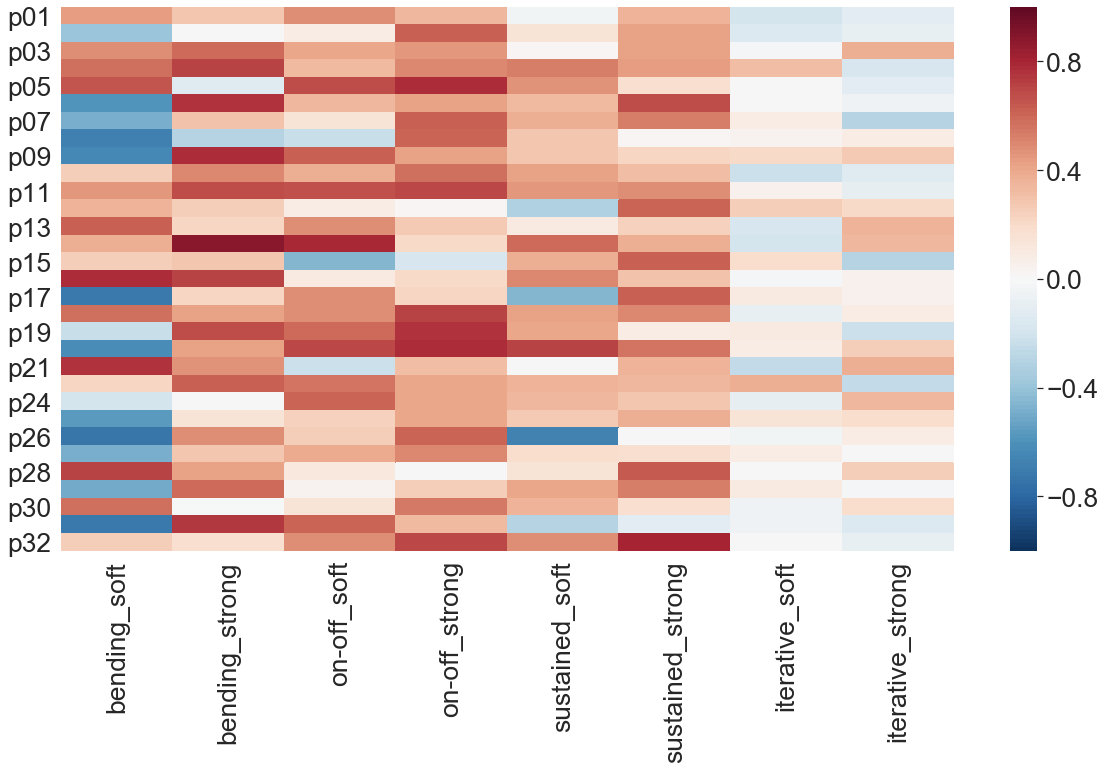

In [106]:
#Heat map of cross correlation coefficients (spearman) of emg (pc) vs sound rms 

meanfq=10

r2_all_pc=[]
p2_all_pc=[]
p2pc_all_pc=[]
for p in participant:
    r_tasks=[]
    p_tasks=[]
    p_tasks2pc=[]
    for t in tasks:
        d1_pc = pca(allof[p]['emg'][t[:-3]])
        d1_pc_df = pd.DataFrame(data=d1_pc)
#         d1_pc_df_dec = decompose(d1_pc_df, meanfq)[0]
#         d1_pc_fin = np.concatenate(np.array(d1_pc_df_dec))
#         d1_norm = norm(d1_pc_fin)
        d1_norm = norm(d1_pc_df.values)
        
        d2_df = allof[p]['rms'][t[:-3]]
#         d2_df = pd.DataFrame(data=allof[p]['rms'][t[:-3]])
#         d2_df_dec = decompose(d2_df, meanfq)[0]
#         d2_fin = np.concatenate(np.array(d2_df_dec))
#         d2_norm = norm(d2_fin)
#         d2_norm_inter = interp_two(d2_norm, d1_norm)
        d2_norm = norm(d2_df.values)
        d2_norm_inter = interp_two(d2_norm, d1_norm)
    
        r_val = spearmanr(d1_norm, d2_norm_inter)
        
        r_tasks.append(round(r_val[0], 2))
        p_tasks2pc.append(r_val[1])
        if r_val[1] < 0.001:
            p_val = '<.001'
            p_tasks.append(p_val)
        else:
            p_tasks.append(round(r_val[1], 2))
    r2_all_pc.append(r_tasks)
    p2_all_pc.append(p_tasks)
    p2pc_all_pc.append(p_tasks2pc)
    
r2_all_pc = pd.DataFrame(data=r2_all_pc)
p2_all_pc = pd.DataFrame(data=p2_all_pc)
p2pc_all_pc = pd.DataFrame(data=p2pc_all_pc)

r2_all_pc.columns = [t[:-3] for t in tasks]
r2_all_pc.index = [p for p in participant]

p2text_pc = np.asarray(p_all_pc)
plt.figure(figsize=(20,10))

sns.heatmap(r2_all_pc, annot=None, fmt='', cmap=sns.color_palette("RdBu_r", 130, desat=0.85), vmin=-1, vmax=1)

# plt.savefig(os.path.join(p_path, "emg_pc_sound_rms_ccc_spearman_nodec.png"), bbox_inches='tight')
# p2pc_all_pc.to_csv(os.path.join(p_path, 'emg_pc_sound_rms_ccc_spearman_nodec.txt'), sep=' ', mode='a')

# Sound

In [107]:
#SPECTRAL CENTROID VS SOFT / STRONG

def sc(people, task, constant=0.01):
    p010 = np.array(allof[people]['snd'][task])
    sr = 22050
#     sb, sa = butter(2, 4000, 'low', fs=sr)
#     p010_f = np.asfortranarray(filtfilt(sb, sa, p010))
    
    sst = librosa.stft(p010+constant)
    sstime = librosa.times_like(sst)
    S, phase = librosa.magphase(librosa.stft(y=p010+constant))
    p010_cent =  librosa.feature.spectral_centroid(S=S)
    p010_cent = np.concatenate(p010_cent.T)
    f1s = int(185/(len(p010)/sr))
    return sstime[:f1s], p010_cent[:f1s], np.mean(p010_cent[:f1s])

all_sc=[]
for p in participant:
    sclist=[]
    for t in tasks:
        sc1 = sc(p, t[:-3])[2]
        sclist.append(sc1)
    all_sc.append(sclist)
all_sc = pd.DataFrame(data=all_sc)
all_sc.columns = [t[:-3] for t in tasks]
all_sc.index = [p for p in participant]

In [108]:
#SPECTRAL CENTROID VS SOFT / STRONG  ----shorter time scale

def sc_short(people, task, constant=0.01):
    p010 = np.array(allof[people]['snd'][task])
    sr = 22050
#     sb, sa = butter(2, 4000, 'low', fs=sr)
#     p010_f = np.asfortranarray(filtfilt(sb, sa, p010))
    
    sst = librosa.stft(p010+constant)
    sstime = librosa.times_like(sst)
    S, phase = librosa.magphase(librosa.stft(y=p010+constant))
    p010_cent =  librosa.feature.spectral_centroid(S=S)
    p010_cent = np.concatenate(p010_cent.T)
    f1s = int(185/(len(p010)/sr)/4)  #250ms
    return sstime[:f1s], p010_cent[:f1s], np.mean(p010_cent[:f1s])

all_sc_s=[]
for p in participant:
    sclists=[]
    for t in tasks:
        sc1s = sc_short(p, t[:-3])[2]
        sclists.append(sc1s)
    all_sc_s.append(sclists)
all_sc_s = pd.DataFrame(data=all_sc_s)
all_sc_s.columns = [t[:-3] for t in tasks]
all_sc_s.index = [p for p in participant]

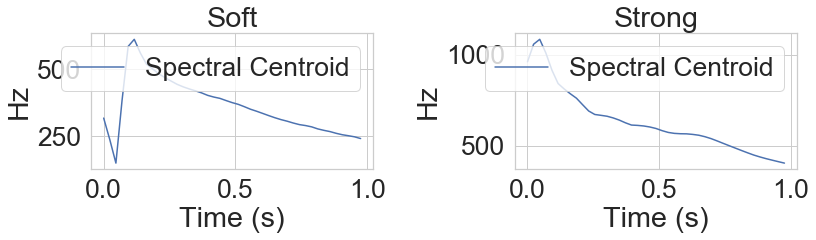

In [109]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(sc('p01', 'sustained_soft')[0], sc('p20', 'sustained_soft')[1], label='Spectral Centroid')
plt.xlabel("Time (s)")
plt.ylabel("Hz")
plt.title('Soft')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(sc('p01', 'sustained_strong')[0], sc('p20', 'sustained_strong')[1], label='Spectral Centroid')
plt.xlabel("Time (s)")
plt.ylabel("Hz")
plt.title('Strong')
plt.legend(loc='upper right')

plt.tight_layout()

In [110]:
print('Soft SC mean: ', sc('p20', 'sustained_soft')[2])
print('Strong SC mean: ', sc('p20', 'sustained_strong')[2])

Soft SC mean:  362.65178956306175
Strong SC mean:  632.1354870168844


In [111]:
snsc_all=[]
for i, t in enumerate(tasks):
    
    scval = pd.DataFrame(all_sc.iloc[:,i].values)
    sclen = len(all_sc.iloc[:,i].values)
    sctname = pd.DataFrame(sclen*[t.split("_", 1)[0].capitalize()])
    scpname = pd.DataFrame([p for p in participant])
    scfinale = pd.concat([scpname,scval,sctname],axis=1)
    snsc_all.append(scfinale)

dynamics_name = pd.DataFrame((31*['Soft'] + 31*['Strong']) *4)
snsc_all=pd.concat([snsc_all[0],snsc_all[1],snsc_all[2],snsc_all[3],snsc_all[4],
                    snsc_all[5],snsc_all[6],snsc_all[7]], axis=0)
snsc_all = snsc_all.reset_index(drop=True)
snsc_all=pd.concat([snsc_all, dynamics_name], axis=1)
snsc_all.columns=['Participant', 'Spectral Centroid (Hz)','Tasks', 'Dynamics']

In [112]:
#Shorter time scale

snsc_all_s=[]
for i, t in enumerate(tasks):
    
    scvals = pd.DataFrame(all_sc_s.iloc[:,i].values)
    sclens = len(all_sc_s.iloc[:,i].values)
    sctnames = pd.DataFrame(sclens*[t.split("_", 1)[0].capitalize()])
    scpnames = pd.DataFrame([p for p in participant])
    scfinales = pd.concat([scpnames,scvals,sctnames],axis=1)
    snsc_all_s.append(scfinales)

snsc_all_s=pd.concat([snsc_all_s[0],snsc_all_s[1],snsc_all_s[2],snsc_all_s[3],snsc_all_s[4],
                    snsc_all_s[5],snsc_all_s[6],snsc_all_s[7]], axis=0)
snsc_all_s = snsc_all_s.reset_index(drop=True)
snsc_all_s=pd.concat([snsc_all_s, dynamics_name], axis=1)
snsc_all_s.columns=['Participant', 'Spectral Centroid (Hz)','Tasks', 'Dynamics']

In [113]:
snsc_all.shape[0] / 31

8.0

In [114]:
scs = snsc_all[snsc_all_s['Dynamics']=='Soft']
scS = snsc_all[snsc_all_s['Dynamics']=='Strong']

sc_tt = pg.ttest(x=scs['Spectral Centroid (Hz)'], y=scS['Spectral Centroid (Hz)'])
print(sc_tt)
print('\n')
print(round(scs['Spectral Centroid (Hz)'].mean(), 2), round(scs['Spectral Centroid (Hz)'].std(),2))
print(round(scS['Spectral Centroid (Hz)'].mean(),2), round(scS['Spectral Centroid (Hz)'].std(),2))

               T  dof       tail         p-val               CI95%   cohen-d  \
T-test -16.98504  246  two-sided  2.436372e-43  [-320.16, -253.62]  2.157102   

             BF10  power  
T-test  5.864e+39    1.0  


299.03 124.24
585.93 141.22


In [115]:
sc_aov = pg.anova(data=snsc_all_s, dv='Spectral Centroid (Hz)', between=['Participant'], 
                      detailed=True, ss_type=1)
print(sc_aov)

        Source            SS   DF             MS         F     p-unc       np2
0  Participant  3.441113e+06   30  114703.750008  1.737169  0.013539  0.193653
1       Within  1.432832e+07  217   66029.118787       NaN       NaN       NaN


In [116]:
scS.head()

,Participant,Spectral Centroid (Hz),Tasks,Dynamics
31,p01,439.599121,Bending,Strong
32,p02,647.676446,Bending,Strong
33,p03,575.096986,Bending,Strong
34,p04,215.239171,Bending,Strong
35,p05,614.194536,Bending,Strong


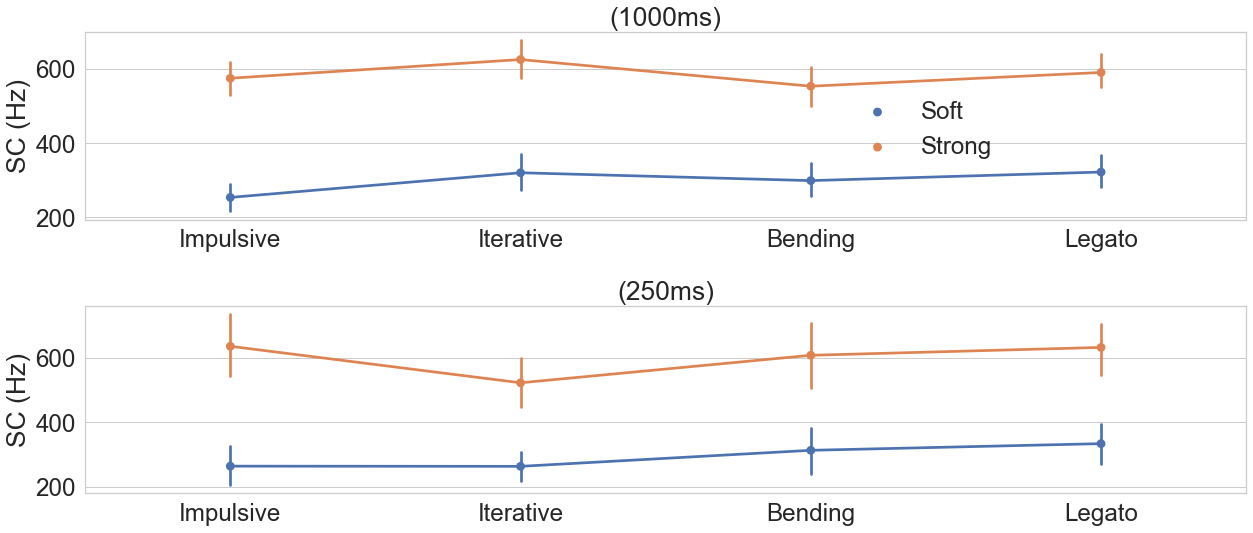

In [190]:
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html

sns.set(style="whitegrid", font_scale=2.2)

f, (ax1, ax2) = plt.subplots(2, figsize=(18,8))

snsc_all['Tasks'] = snsc_all['Tasks'].str.replace('Sustained','Impulsive')
snsc_all['Tasks'] = snsc_all['Tasks'].str.replace('On-off','Legato')

snsc_all_s['Tasks'] = snsc_all_s['Tasks'].str.replace('Sustained','Impulsive')
snsc_all_s['Tasks'] = snsc_all_s['Tasks'].str.replace('On-off','Legato')

#1s
long = sns.pointplot(x="Tasks", y="Spectral Centroid (Hz)", data=snsc_all, hue='Dynamics', 
           order=["Impulsive", "Iterative", "Bending", "Legato"], legend_out=True, ax=ax1) 
long.title.set_text('(1000ms)')
long.set_xlabel('')
long.set_ylabel('SC (Hz)')

long.legend(loc='center right', bbox_to_anchor=(0.0001, 0.43, 0.8, 0.1), framealpha=0.01)

#250ms
short = sns.pointplot(x="Tasks", y="Spectral Centroid (Hz)", data=snsc_all_s, hue='Dynamics', 
           order=["Impulsive", "Iterative", "Bending", "Legato"], legend_out=False, ax=ax2) 
short.title.set_text('(250ms)')
short.set_xlabel('')
short.set_ylabel('SC (Hz)')
short.get_legend().remove()

plt.tight_layout()


# plt.savefig(os.path.join(p_path, "sc_2plots.png"), bbox_inches='tight')
plt.show()

In [118]:
def mean_of_all_sc(t, ax):
    '''return the mean array of the same SC task accross all participants'''
    
    concat=[]
    for idx, p in enumerate(participant):
        df = sc(p, t)[ax]
        dfe=pd.DataFrame(df)
        if ax == 0:
            dfe.columns = ["Time"]
        else:
            dfe.columns = ["SC mean"]
    
        concat.append(dfe)
    
    concat = pd.concat(concat)
    by_row_index = concat.groupby(concat.index)
    df_means = by_row_index.mean()
    
    return df_means

In [119]:
# sc('p01', 'bending_soft')[:2]

In [120]:
int(185/(len(allof['p01']['snd']['bending_soft'])/22050)/4)

10

In [121]:
mean_of_all_sc('sustained_strong', 1).max()

SC mean    808.658938
dtype: float64

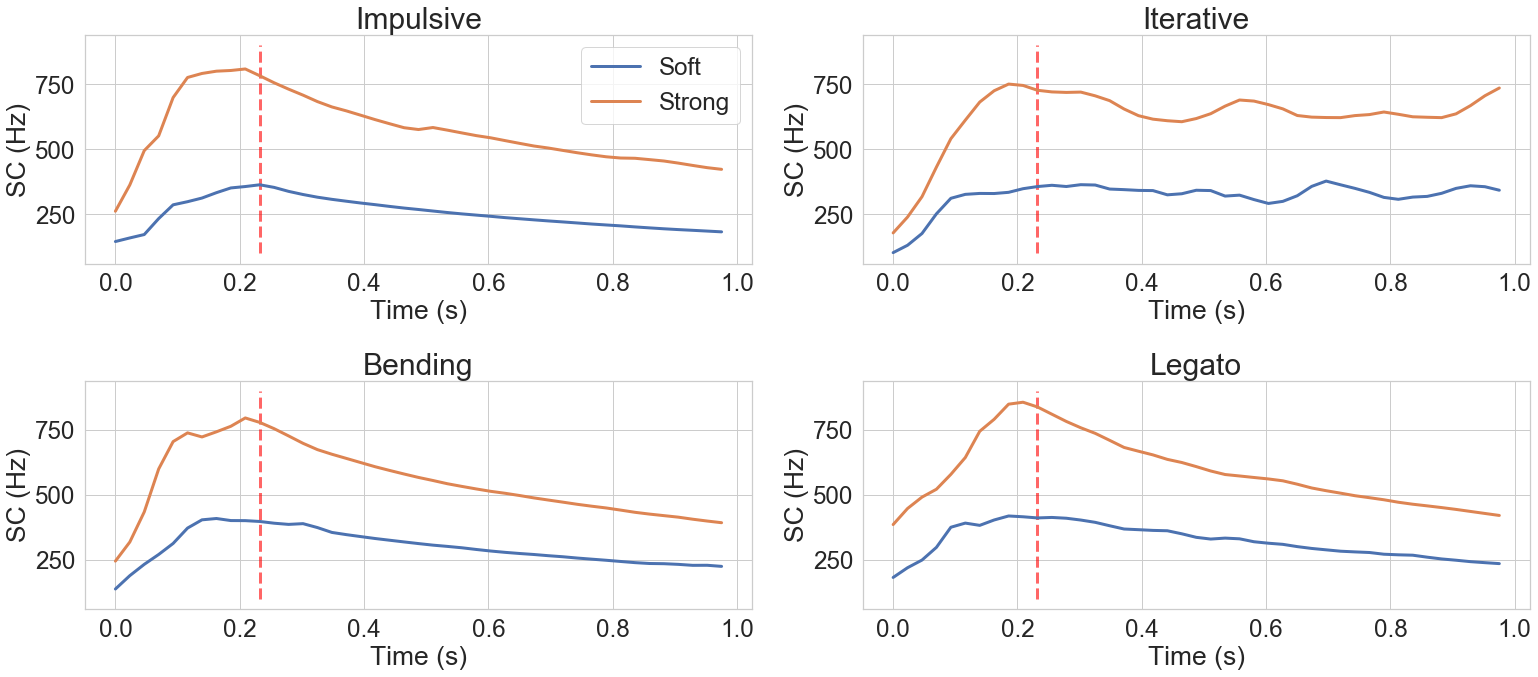

In [122]:
sns.set(style="whitegrid", font_scale=2.2)

cutvline = int(185/(len(allof['p01']['snd']['bending_soft'])/22050)/4)

scmin=100
scmax=900
linewidth=3
fontsize=30

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(22, 10))
# fig.text(0.5, 0.0005, 'Time (s)', ha='center', fontsize=35)
# fig.text(0.0005, 0.5, 'SC (Hz)', va='center', rotation='vertical', fontsize=35)


axs[0, 0].plot(mean_of_all_sc('sustained_soft', 0), mean_of_all_sc('sustained_soft', 1), label='Soft',
              linewidth=linewidth)
axs[0, 0].plot(mean_of_all_sc('sustained_strong', 0), mean_of_all_sc('sustained_strong', 1), label='Strong',
              linewidth=linewidth)
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("SC (Hz)")
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_title('Impulsive', fontsize=fontsize)
axs[0, 0].vlines(mean_of_all_sc('sustained_soft', 0).loc[cutvline], 
           scmin, scmax, linewidth=linewidth,
           linestyles='--', color='red', alpha=0.6)


axs[0, 1].plot(mean_of_all_sc('iterative_soft', 0), mean_of_all_sc('iterative_soft', 1), linewidth=linewidth)
axs[0, 1].plot(mean_of_all_sc('iterative_strong', 0), mean_of_all_sc('iterative_strong', 1), linewidth=linewidth)
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_ylabel("SC (Hz)")
axs[0, 1].set_title('Iterative', fontsize=fontsize)
axs[0, 1].vlines(mean_of_all_sc('sustained_soft', 0).loc[cutvline], 
           scmin, scmax, linewidth=linewidth,
           linestyles='--', color='red', alpha=0.6)


axs[1, 0].plot(mean_of_all_sc('bending_soft', 0), mean_of_all_sc('bending_soft', 1), linewidth=linewidth)
axs[1, 0].plot(mean_of_all_sc('bending_strong', 0), mean_of_all_sc('bending_strong', 1), linewidth=linewidth)
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("SC (Hz)")
axs[1, 0].set_title('Bending', fontsize=fontsize)
axs[1, 0].vlines(mean_of_all_sc('sustained_soft', 0).loc[cutvline], 
           scmin, scmax, linewidth=linewidth,
           linestyles='--', color='red', alpha=0.6)


axs[1, 1].plot(mean_of_all_sc('on-off_soft', 0), mean_of_all_sc('on-off_soft', 1), linewidth=linewidth)
axs[1, 1].plot(mean_of_all_sc('on-off_strong', 0), mean_of_all_sc('on-off_strong', 1), linewidth=linewidth)
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("SC (Hz)")
axs[1, 1].set_title('Legato', fontsize=fontsize)
axs[1, 1].vlines(mean_of_all_sc('sustained_soft', 0).loc[cutvline], 
           scmin, scmax, linewidth=linewidth,
           linestyles='--', color='red', alpha=0.6)

fig.tight_layout()
# plt.savefig(os.path.join(p_path, "sc_means.png"), bbox_inches='tight')
plt.show()

In [123]:
70/60/4  #this is the time for the second 16th note in the first beat   
#THINK MORE ABOUT WHERE TO CUT FOR THE SHORT SCALE!!

0.2916666666666667

In [124]:
# df = pd.DataFrame(np.random.randint(0,100,size=(100, 1)), columns=["val"])
# df["cond"] = np.random.choice(["t1","t2","t3","t4"],100)
# df["unit"] = np.random.choice(["u1","u2","u3","u4"],100)

# f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
# sns.pointplot(x="cond", y="val", data=df, ci=68.3, legend_out=False, ax=ax1)
# sns.pointplot(x="cond", y="val", data=df, ci=68.3, legend_out=False, palette=sns.color_palette(["#000000", "#E69F00", "#56B4E9", "#009E73","#F0E442", "#0072B2", "#D55E00", "#CC79A7"]), ax=ax2)
# sns.pointplot(x="cond", y="val", hue="unit", data=df, ci=68.3, legend_out=False, ax=ax3)
# sns.pointplot(x="cond", y="val", hue="unit", data=df, ci=68.3, legend_out=False, palette=sns.color_palette(["#000000", "#E69F00", "#56B4E9", "#009E73","#F0E442", "#0072B2", "#D55E00", "#CC79A7"]), ax=ax4)
# plt.show()

on-off_strong_70


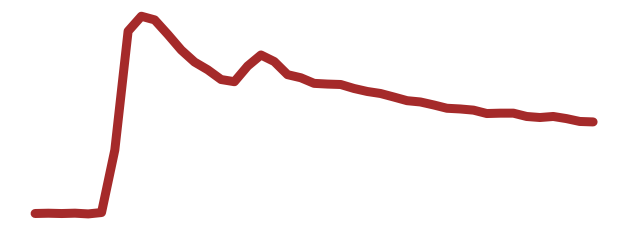

In [125]:
am = 3
print(tasks[am])

ttt = librosa.frames_to_time(range(len(allof['p27']['emg'][tasks[am][:-3]].ch1)), sr=2000, hop_length=25)

sc27 = sc('p27', tasks[am][:-3])

Sc = SSA(sc27[1], 10)
trendsc = Sc.reconstruct(0)

plt.figure(figsize=(11,4))
plt.plot(sc27[0], sc27[1], color='brown', linewidth=9.0, label='Spectral centroid')
# plt.legend(fontsize=30)
plt.xticks([])
plt.yticks([])
# plt.xlim(0.069, sc27[0][-1]) #sustained soft
# plt.xlim(0.029, sc27[0][-1]) #sustained strong
plt.axis('off')
# plt.savefig(os.path.join(p_path, tasks[am][:-3]+ "_sc.png"), bbox_inches='tight', transparent=True)
plt.show()

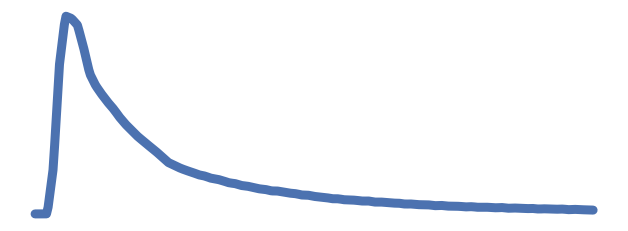

In [126]:
# am = 0

ttt = librosa.frames_to_time(range(len(allof['p27']['emg'][tasks[am][:-3]].ch1)), sr=2000, hop_length=25)

ramss = interp_two(allof['p27']['rms'][tasks[am][:-3]], 
                         allof['p27']['emg'][tasks[am][:-3]].ch1)

plt.figure(figsize=(11,4))
plt.plot(ttt, ramss, label='RMS', linewidth=9.0)
# plt.legend(fontsize=30)
plt.xticks([])
plt.yticks([])
plt.axis('off')
# plt.savefig(os.path.join(p_path, tasks[am][:-3]+ "_rms.png"), bbox_inches='tight', transparent=True)
plt.show()

In [127]:
#SEGMENT MOCAP DAT!

date = '20191108'
subject = 'p27'

task = tasks[6]
seqz = 3
print(task)
print('Seg nr:', seqz)

p27_grounds = [13.608753,   #bend s
               13.508753,   #bend S
               13.762313,   #legato s
               13.439093,   #legato S
               13.142494,   #imp s
               31.811338,   #imp S
               13.287075,   # it s
               18.975964]   # it S

# p27_segs = [4,4,3,3,2,5,5,1]

ground = p27_grounds[tasks.index(task)] #check the 'ground' in the Delsys_onsets notebook
#it soft correct gr: 12.887075, it strong: 18.575964

metropath = os.path.join(datdir, date, subject, task+'/')

#metro timeline
p = os.path.join(metropath, 'timeline.txt')
file = open(p, 'r')
metro_timeline = file.read().split(',')
metro_timeline = [float(i) for i in metro_timeline]
file.close()

# 1 bar-segments

marker = [
  (15, 20),
  (39, 44),
  (63, 68),
  (87, 91),
  (111, 116),
  (135, 139)]

seg = []

for m in marker:
    start = m[0]
    end = m[1]
    seg.append(metro_timeline[start])
    seg.append(metro_timeline[end])

    
def get_time(y, sr=200):
    return np.linspace(0, len(y)/sr, len(y))


shift = seg[0] - ground
real_seg = [x - shift for x in seg]
print(real_seg)

mtsv = os.path.join('/Users/cagrierdem/Desktop/dat/guit_lab/mocap/tsv/', subject + "_" + task + ".tsv")
mdf = pd.read_csv(mtsv, sep="\t", header=10)

mcut_points = []
for s in range(12):
    cut_val = mdf.loc[mdf['Time']==round(real_seg[s],2)].index.values[0]
    mcut_points.append(cut_val)

print('Total cut poits: {}'.format(len(mcut_points)))

mew_cut_points = mcut_points
m1 = mcut_points[1] - mcut_points[0]

mew_cut_points[3] = mcut_points[2] + m1
mew_cut_points[5] = mcut_points[4] + m1
mew_cut_points[7] = mcut_points[6] + m1
mew_cut_points[9] = mcut_points[8] + m1
mew_cut_points[11] = mcut_points[10] + m1

m1 = mdf.iloc[mew_cut_points[0]:mew_cut_points[1],:].reset_index(drop=True)
m2 = mdf.iloc[mew_cut_points[2]:mew_cut_points[3],:].reset_index(drop=True)
m3 = mdf.iloc[mew_cut_points[4]:mew_cut_points[5],:].reset_index(drop=True)
m4 = mdf.iloc[mew_cut_points[6]:mew_cut_points[7],:].reset_index(drop=True)
m5 = mdf.iloc[mew_cut_points[8]:mew_cut_points[9],:].reset_index(drop=True)
m6 = mdf.iloc[mew_cut_points[10]:mew_cut_points[11],:].reset_index(drop=True)

mz = [m1,m2,m3,m4,m5,m6]
m_vels_l=[]
m_vels_r=[]

for m in mz:
    xdiff_l = np.diff(m["hand_left X"])
    ydiff_l = np.diff(m["hand_left X"])
    zdiff_l = np.diff(m["hand_left Z"])
    velocity_l = np.sqrt(xdiff_l**2 + ydiff_l**2 + zdiff_l**2) / 0.005
    x = m.Time[:-1]
    m_vels_l.append([x, velocity_l])
    
    xdiff_r = np.diff(m["hand_right X"])
    ydiff_r = np.diff(m["hand_right X"])
    zdiff_r = np.diff(m["hand_right Z"])
    velocity_r = np.sqrt(xdiff_r**2 + ydiff_r**2 + zdiff_r**2) / 0.005
    m_vels_r.append([x, velocity_r])

iterative_soft_70
Seg nr: 3
[13.287075, 17.579583125305177, 33.88711686630249, 38.179439978790285, 54.488736825180055, 58.78037281532288, 75.08894200820923, 78.52310486335755, 95.69121070404053, 99.98273797531128, 116.29433508415222, 119.72716994781494]
Total cut poits: 12


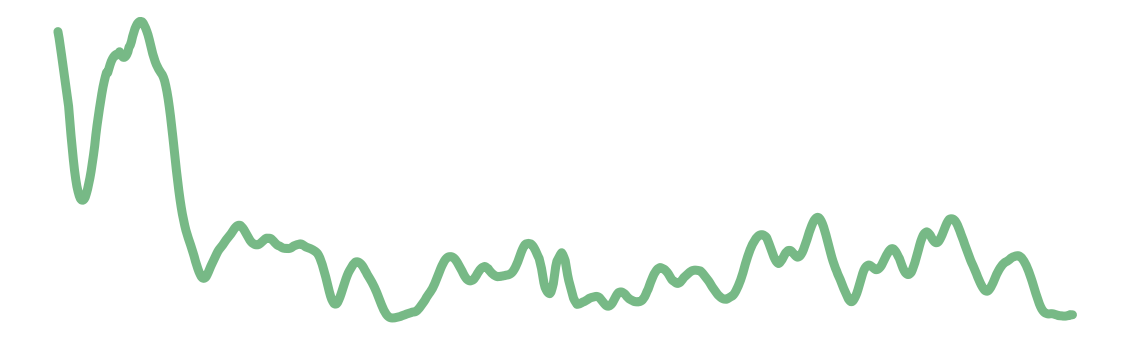

In [128]:
# seqz = 1

Mcr = SSA(m_vels_r[seqz-1][1], 10)
trend_mr = Mcr.reconstruct(0)

Mcl = SSA(m_vels_l[seqz-1][1], 10)
trend_ml = Mcl.reconstruct(0)

mt = np.linspace(ttt[0],ttt[-1], m_vels_r[seqz-1][1].size)

plt.figure(figsize=(20,6))
# plt.plot(mt, trend_mr, label='Right hand', alpha=0.9, color='m')
plt.plot(mt, trend_ml, label='Left hand', alpha=0.8, color='g', linewidth=9.0)
plt.xticks([])
plt.yticks([])
plt.axis('off')
# plt.legend(fontsize=35)
# plt.savefig(os.path.join(p_path, task+ "_mocap.png"), bbox_inches='tight', transparent=True)
plt.show()
# print(mtask)


# plt.figure(figsize=(16,4))
# plt.plot(m_vels_r[seqz][0], m_vels_r[seqz][1])
# plt.plot(m_vels_l[seqz][0], m_vels_l[seqz][1])

In [129]:
# shift = metro_timeline[i] - ground
# start = metro_timeline[i] - shift
# end = metro_timeline[i+4] - shift
# print(start, end)

# sns.set()
# seg = df.loc[(df.Time >= start) & (df.Time <= end)]
# plt.figure(figsize=(20, 10))

# plt.subplot(2, 1, 1)
# plt.title("p27 left hand velocity " + task)
# xdiff = np.diff(seg["hand_left X"])
# ydiff = np.diff(seg["hand_left X"])
# zdiff = np.diff(seg["hand_left Z"])
# velocity = np.sqrt(xdiff**2 + ydiff**2 + zdiff**2) / 0.005

# np.save('/content/gdrive/My Drive/tsv/npy/'+person+"_"+task+"_left_hand_velocity", velocity)
# x = seg.Time[:-1]
# plt.plot(x, velocity)

# plt.subplot(2, 1, 2)
# plt.title("p27 right hand velocity "+ task)
# xdiff = np.diff(seg["hand_right X"])
# ydiff = np.diff(seg["hand_right X"])
# zdiff = np.diff(seg["hand_right Z"])
# velocity = np.sqrt(xdiff**2 + ydiff**2 + zdiff**2) / 0.005

# np.save('/content/gdrive/My Drive/tsv/npy/'+person+"_"+task+"_right_hand_velocity", velocity)
# x = seg.Time[:-1]
# plt.plot(x, velocity)